# H3 Examples

In this notebook I implement examples of the use of H3 for spatial analysis in the Twitter project:

1. I start by comparing measuring census radius areas in Buenos Aires, and compare those to different hexagons sizes, called "resolutions".
2. I also show the implementation of h3.polyfill which retrieves the set of polygons that fit main area under analysis. In this example the Metropolitan Area of Buenos Aires.
3. I assign each tweet in the database the corresponding hexagon. I persist this information in the MongoDB database by using a method that is efficient for a large database application.


In [1]:
from h3 import h3

In [2]:
h3_address = h3.geo_to_h3(37.3615593, -122.0553238, 5) # lat, lng, hex resolution
hex_center_coordinates = h3.h3_to_geo(h3_address) # array of [lat, lng]
hex_boundary = h3.h3_to_geo_boundary(h3_address) # array of arrays of [lat, lng]
hex_boundary

[[37.27135586673191, -121.91508032705622],
 [37.353926450852256, -121.86222328902491],
 [37.42834118609436, -121.92354999630152],
 [37.42012867767779, -122.0377349642703],
 [37.33755608435299, -122.09042892904398],
 [37.26319797461824, -122.02910130919]]

# 1. Hex resolution analysis for Buenos Aires

In [3]:
import os,sys,inspect
import geopandas as gpd
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
barrios = gpd.read_file(currentdir+"/data/barrios_badata.shp")
Provincia = gpd.read_file(currentdir+"/data/Provincia_2010.shp")
#radios = gpd.read_file(currentdir+"/data/radiosunificados2010.shp")
#caba_y_pba=radios.loc[(radios["formula"].str.startswith('a06'))|(radios["formula"].str.startswith('a02'))].plot()
amba=gpd.read_file(currentdir+"/data/radios_amba_2010.shp")


In [4]:
caba=amba.loc[(amba["formula"].str.startswith('a02'))]

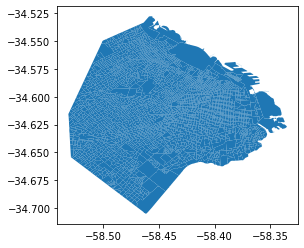

In [5]:
caba.plot()

## Comparing the censal radius sizes with hex resolutions

El radio censal mediano tiene 35,515 metros cuadrados (es decir un poco mas de 3 manzanas de 100x100 metros) es decir 0.035 kilometros cuadrados. Como se puede ver tambien hay outliers.
According to h3 documentation https://h3geo.org/#/documentation/core-library/resolution-table
Resolution 9 has a size of	0.1053325 km2
Resolution 10 has a size of  0.0150475 km2
So median census radiuses will be anywhere between
https://h3geo.org/#/documentation/core-library/resolution-tablez

/home/rickhunter/miniconda3/envs/twitteranalysis/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


count    3555.000000
mean        0.057342
std         0.168944
min         0.004509
25%         0.018592
50%         0.035515
75%         0.062872
max         6.311092
Name: areas_km2, dtype: float64


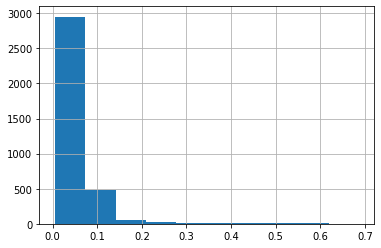

In [200]:
crs_ciudad={'proj': 'tmerc',
 'lat_0': -34.6297166,
 'lon_0': -58.4627,
 'k': 0.999998,
 'x_0': 100000,
 'y_0': 100000,
 'ellps': 'intl',
 'units': 'm',
 'no_defs': True}

def area_statistics(gdf):
    gdf2=gdf.copy()
    gdf2=gdf2.to_crs(crs_ciudad)
    gdf2['areas_km2']=gdf2.geometry.area/ 10**6
    print(gdf2['areas_km2'].describe())
    gdf2.loc[gdf2['areas_km2']<0.75]['areas_km2'].hist()

area_statistics(caba)

In the case of AMBA, naturally the median censal radius is larger, with a median of 0.11 km2 

/home/rickhunter/miniconda3/envs/twitteranalysis/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


count    15124.000000
mean         0.927855
std          6.838027
min          0.003347
25%          0.062444
50%          0.112018
75%          0.190745
max        243.313502
Name: areas_km2, dtype: float64


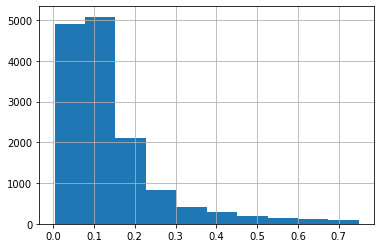

In [201]:
area_statistics(amba)

# 2. Filling AMBA with hexagons

## Preparing AMBA for hex fill

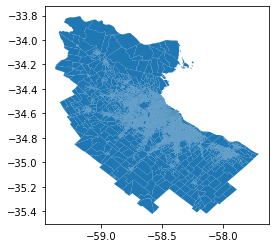

In [103]:
amba.plot()

In [202]:
print('number of censal radiuses in amba', amba.shape[0])

number of censal radiuses in amba 15124


In [106]:
amba['one']=1
ambadissolved=amba.dissolve(by='one')

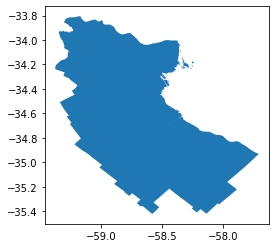

In [111]:
ambadissolved.plot()

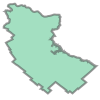

In [163]:
# notar que me voy a quedar solo con el poligono principal. No voy a trabajar con las islas
ambadissolved.geometry[1][0]

## Implementing h3.polyfill 

El procedimiento que sigue saca el campo geometry de dentro del GeoJSON. Para eso antes transforme el geopandas a geojson con _geointerface_

In [178]:
from pandas.io.json import json_normalize
geojson=gpd.GeoSeries(ambadissolved.geometry[1][0]).__geo_interface__
geojson=pd.DataFrame(json_normalize(geojson))['features'][0][0]['geometry']

In [179]:
set_hexagons = h3.polyfill(geo_json = geojson, res = 9, geo_json_conformant = True)
list_hexagons = list(set_hexagons)
print("the subzone was filled with ", len(list_hexagons), "hexagons at resolution 9")

the subzone was filled with  190826 hexagons at resolution 9


In [234]:
list_hexagons[0:10]

['89c2e14938bffff',
 '89c2eec752bffff',
 '89c2ee4ad4bffff',
 '89c2e3a89afffff',
 '89c2e025e9bffff',
 '89c2e14d1bbffff',
 '89c2e0772b7ffff',
 '89c2e015bd3ffff',
 '89c2e3918b3ffff',
 '89c2e31222bffff']

Example of h3 to geo_boundary (list of lists of coordinates)

In [208]:
hextest=h3.h3_to_geo_boundary(h3_address=list_hexagons[0],geo_json=False)
hextest

[[-34.78854934638241, -58.80303207865535],
 [-34.78997888277937, -58.80400177297753],
 [-34.791182435915545, -58.80314324698708],
 [-34.79095644981529, -58.8013150526769],
 [-34.78952693452643, -58.800345408551834],
 [-34.788323384229976, -58.801203908539264]]

## Two custom made functions to convert h3 to shapely and geopandas

In [2]:
from shapely.geometry import Polygon

def hex_to_polygon(hexid):
    """transforms single hexid to shapely polygon"""
    list_of_coords_list=h3.h3_to_geo_boundary(h3_address=hexid,geo_json=False)
    return Polygon([tuple(i) for i in list_of_coords_list])
    


def hexlist_to_geodataframe(list_hexagons): 
    """transforms list of hex ids (h3 indexes) to GeoDataFrame"""
    df=pd.DataFrame(list_hexagons, columns=['hexid'])
    def f(x):
        #return h3.h3_to_geo_boundary(h3_address=x['hexid'],geo_json=False)
        return hex_to_polygon(x['hexid'])  

    gdf = gpd.GeoDataFrame(df, geometry=df.apply(f, axis=1))
    return gdf


## Plot of AMBA filled with Polygons

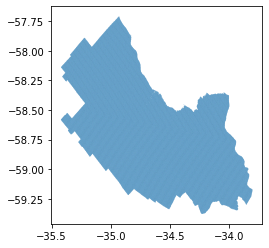

In [233]:
gdf.plot()

# 3. Spatial Index a tweets in a mongo collection with H3, and update, in chunks

The plan to update the collection of tweets with hex indexes is the following: 
                   i. Iteration of the collection in chunks. 
                    ii. Documents are transformed to  dataframes of a fixed size.                    
                    iii. the geo_to_h3 function is implemented to all documents with the pandas apply method
                    iv.  Another apply method creates UpdateOne requests that will be handled by bulkwrite.
                                        

In [237]:
import communicationwmongo as commu
import home_location as home
import pandas as pd
import analysis as a
db=commu.connecttoLocaldb(database='twitter') 

## Function implementing apply and  Update requests

In [317]:
#2. Apply geo_to_h3 to a chunk of tweets and prepare bulk request

from pymongo import InsertOne, UpdateOne

def add_hexs_and_prepare_bulk_request(df):
    """
    :param df: dataframe of tweets (a chunk of the tweets collection)
    :return: request job for bulk insert

    Example:
    [InsertOne({'_id': ObjectId('5e10ced16e7ccd7b44e9ee07'), 'hex': {'9': '89dd6876033ffff'}}),

    """
    # apply geo_to_h3
    resolution=9
    df2=df['location'].apply(lambda row: h3.geo_to_h3(row["coordinates"][0],row["coordinates"][1],resolution))
    df2.name='9'

    resolution=10
    df3=df['location'].apply(lambda row: h3.geo_to_h3(row["coordinates"][0],row["coordinates"][1],resolution))
    df3.name='10'

    # join (concatenating) tweets with new data
    df4=pd.concat([df,df2,df3], axis=1)

    # Esta funcion me arma el diccionario y lo mete en el InsertOne method que luego voy a pasar en formato de lista
    def f(x):
        #return InsertOne({'_id': ObjectId(x['_id']),'hex':{'9':x['9'],'10':x['10']}})
        return UpdateOne({'_id': ObjectId(x['_id'])}, {'$set': {'hex':{'9':x['9'],'10':x['10']}}})
    #            'geometry': gpd.GeoSeries(x['geometry']).__geo_interface__['features'][0]['geometry']}

    # return list of requests  
    return list(df4.apply(f, axis=1))


## Smart in chunks iterator 

This is the preferred method to make mongodb requests in chunks. The iterator asks for all documents with ids larger than the  last objectid that was processed. the limit() method ensures fixed size.
After updates have been created by the add_hexs_and_prepare_bulk_request function, inserts are made in chunks with Mongo BulkWrite.

In [322]:
from pymongo import InsertOne, UpdateOne

start_time=time.time()


chunksize=1000
collectionsize=db.tweets.count()

iteration=1

while iteration<(int(collectionsize/chunksize)+1):
    iter_start_time=time.time()
    if iteration>1:
        cursor=db.tweets.find({'_id' : { '$gt' : last_object_id} }).sort( '_id', 1  ).limit(chunksize)
        #alternatively I could have done '$lt' and sort -1 as suggest in the documentation
    else:
        cursor=db.tweets.find().sort( '_id', 1  ).limit(chunksize)

    df=pd.DataFrame(list(cursor))
    
    requests=add_hexs_and_prepare_bulk_request(df)
    
    try:
        db.tweets.bulk_write(requests, ordered=False)
    except BulkWriteError as bwe:
        pprint(bwe.details)

    # obtengo el last id del dataframe
    last_object_id=df.iloc[-1]['_id']

    
    iter_end_time=time.time()
    print(' iter:',iteration,' time:',iter_end_time-iter_start_time)
    iteration+=1
    
end_time=time.time()
print('total elapsed time:',end_time-start_time)


/home/rickhunter/miniconda3/envs/twitteranalysis/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """


 iter: 1  time: 0.18856477737426758
 iter: 2  time: 0.1536118984222412
 iter: 3  time: 0.17857122421264648
 iter: 4  time: 0.11806225776672363
 iter: 5  time: 0.15631556510925293
 iter: 6  time: 0.1842179298400879
 iter: 7  time: 0.14249539375305176
 iter: 8  time: 0.12253737449645996
 iter: 9  time: 0.16074466705322266
 iter: 10  time: 0.12230134010314941
 iter: 11  time: 0.1133267879486084
 iter: 12  time: 0.1434028148651123
 iter: 13  time: 0.13707661628723145
 iter: 14  time: 0.12091374397277832
 iter: 15  time: 0.1187746524810791
 iter: 16  time: 0.1235196590423584
 iter: 17  time: 0.12253355979919434
 iter: 18  time: 0.11464858055114746
 iter: 19  time: 0.13483166694641113
 iter: 20  time: 0.1214597225189209
 iter: 21  time: 0.14648008346557617
 iter: 22  time: 0.1098792552947998
 iter: 23  time: 0.20323634147644043
 iter: 24  time: 0.1567068099975586
 iter: 25  time: 0.138016939163208
 iter: 26  time: 0.11534595489501953
 iter: 27  time: 0.12422871589660645
 iter: 28  time: 0.12

 iter: 222  time: 0.10886788368225098
 iter: 223  time: 0.11614298820495605
 iter: 224  time: 0.11959528923034668
 iter: 225  time: 0.10915660858154297
 iter: 226  time: 0.1222543716430664
 iter: 227  time: 0.10725069046020508
 iter: 228  time: 0.13408684730529785
 iter: 229  time: 0.12124752998352051
 iter: 230  time: 0.12113499641418457
 iter: 231  time: 0.10767865180969238
 iter: 232  time: 0.11898398399353027
 iter: 233  time: 0.10991168022155762
 iter: 234  time: 0.11253952980041504
 iter: 235  time: 0.10982465744018555
 iter: 236  time: 0.11251568794250488
 iter: 237  time: 0.13504719734191895
 iter: 238  time: 0.11935544013977051
 iter: 239  time: 0.11261439323425293
 iter: 240  time: 0.11353230476379395
 iter: 241  time: 0.13301801681518555
 iter: 242  time: 0.11818552017211914
 iter: 243  time: 0.11020326614379883
 iter: 244  time: 0.12370944023132324
 iter: 245  time: 0.1193690299987793
 iter: 246  time: 0.11461281776428223
 iter: 247  time: 0.11771583557128906
 iter: 248  ti

 iter: 440  time: 0.1508636474609375
 iter: 441  time: 0.11415433883666992
 iter: 442  time: 0.1116788387298584
 iter: 443  time: 0.10886740684509277
 iter: 444  time: 0.1332254409790039
 iter: 445  time: 0.12907099723815918
 iter: 446  time: 0.13437104225158691
 iter: 447  time: 0.11903238296508789
 iter: 448  time: 0.13470864295959473
 iter: 449  time: 0.11124634742736816
 iter: 450  time: 0.10930943489074707
 iter: 451  time: 0.1150660514831543
 iter: 452  time: 0.21310663223266602
 iter: 453  time: 0.10645198822021484
 iter: 454  time: 0.16115164756774902
 iter: 455  time: 0.14943337440490723
 iter: 456  time: 0.13343429565429688
 iter: 457  time: 0.19678544998168945
 iter: 458  time: 0.12002348899841309
 iter: 459  time: 0.11184978485107422
 iter: 460  time: 0.15704989433288574
 iter: 461  time: 0.1537761688232422
 iter: 462  time: 0.13550019264221191
 iter: 463  time: 0.12482166290283203
 iter: 464  time: 0.11438965797424316
 iter: 465  time: 0.18335700035095215
 iter: 466  time:

 iter: 657  time: 0.13666272163391113
 iter: 658  time: 0.19668149948120117
 iter: 659  time: 0.14185714721679688
 iter: 660  time: 0.11992073059082031
 iter: 661  time: 0.12070918083190918
 iter: 662  time: 0.1280531883239746
 iter: 663  time: 0.1372983455657959
 iter: 664  time: 0.15840625762939453
 iter: 665  time: 0.12025785446166992
 iter: 666  time: 0.10769319534301758
 iter: 667  time: 0.10931825637817383
 iter: 668  time: 0.11629033088684082
 iter: 669  time: 0.13293051719665527
 iter: 670  time: 0.11761689186096191
 iter: 671  time: 0.13710403442382812
 iter: 672  time: 0.11261630058288574
 iter: 673  time: 0.12962722778320312
 iter: 674  time: 0.12157487869262695
 iter: 675  time: 0.14514613151550293
 iter: 676  time: 0.12043547630310059
 iter: 677  time: 0.11979556083679199
 iter: 678  time: 0.1167595386505127
 iter: 679  time: 0.1443767547607422
 iter: 680  time: 0.11688613891601562
 iter: 681  time: 0.12534189224243164
 iter: 682  time: 0.10912513732910156
 iter: 683  time

 iter: 874  time: 0.1117398738861084
 iter: 875  time: 0.12384533882141113
 iter: 876  time: 0.1238558292388916
 iter: 877  time: 0.11493372917175293
 iter: 878  time: 0.11159586906433105
 iter: 879  time: 0.10853910446166992
 iter: 880  time: 0.1285398006439209
 iter: 881  time: 0.10990500450134277
 iter: 882  time: 0.1156163215637207
 iter: 883  time: 0.10750937461853027
 iter: 884  time: 0.13496160507202148
 iter: 885  time: 0.11824488639831543
 iter: 886  time: 0.1081082820892334
 iter: 887  time: 0.11465907096862793
 iter: 888  time: 0.12458515167236328
 iter: 889  time: 0.12058568000793457
 iter: 890  time: 0.1124272346496582
 iter: 891  time: 0.11793208122253418
 iter: 892  time: 0.11406445503234863
 iter: 893  time: 0.11937856674194336
 iter: 894  time: 0.12603330612182617
 iter: 895  time: 0.1075737476348877
 iter: 896  time: 0.11047911643981934
 iter: 897  time: 0.13883590698242188
 iter: 898  time: 0.12163805961608887
 iter: 899  time: 0.11105227470397949
 iter: 900  time: 0

 iter: 1090  time: 0.11771464347839355
 iter: 1091  time: 0.10346579551696777
 iter: 1092  time: 0.11526608467102051
 iter: 1093  time: 0.12616777420043945
 iter: 1094  time: 0.1381673812866211
 iter: 1095  time: 0.11044621467590332
 iter: 1096  time: 0.15638399124145508
 iter: 1097  time: 0.15694737434387207
 iter: 1098  time: 0.11675429344177246
 iter: 1099  time: 0.10877609252929688
 iter: 1100  time: 0.12013912200927734
 iter: 1101  time: 0.14407944679260254
 iter: 1102  time: 0.12283205986022949
 iter: 1103  time: 0.11201047897338867
 iter: 1104  time: 0.11333942413330078
 iter: 1105  time: 0.11552953720092773
 iter: 1106  time: 0.13053250312805176
 iter: 1107  time: 0.14764881134033203
 iter: 1108  time: 0.12679791450500488
 iter: 1109  time: 0.1531085968017578
 iter: 1110  time: 0.12369441986083984
 iter: 1111  time: 0.11325812339782715
 iter: 1112  time: 0.10760688781738281
 iter: 1113  time: 0.22571253776550293
 iter: 1114  time: 0.11733698844909668
 iter: 1115  time: 0.173987

 iter: 1303  time: 0.11668229103088379
 iter: 1304  time: 0.11931681632995605
 iter: 1305  time: 0.11329507827758789
 iter: 1306  time: 0.11926579475402832
 iter: 1307  time: 0.13167452812194824
 iter: 1308  time: 0.11658835411071777
 iter: 1309  time: 0.12804889678955078
 iter: 1310  time: 0.11948299407958984
 iter: 1311  time: 0.12387895584106445
 iter: 1312  time: 0.11433577537536621
 iter: 1313  time: 0.10894417762756348
 iter: 1314  time: 0.11596488952636719
 iter: 1315  time: 0.1202549934387207
 iter: 1316  time: 0.10552740097045898
 iter: 1317  time: 0.10838723182678223
 iter: 1318  time: 0.1105198860168457
 iter: 1319  time: 0.10993528366088867
 iter: 1320  time: 0.11339426040649414
 iter: 1321  time: 0.11419057846069336
 iter: 1322  time: 0.10799312591552734
 iter: 1323  time: 0.11148524284362793
 iter: 1324  time: 0.13181781768798828
 iter: 1325  time: 0.11082243919372559
 iter: 1326  time: 0.11131119728088379
 iter: 1327  time: 0.11772561073303223
 iter: 1328  time: 0.123788

 iter: 1515  time: 0.15960168838500977
 iter: 1516  time: 0.15989160537719727
 iter: 1517  time: 0.20252156257629395
 iter: 1518  time: 0.17456364631652832
 iter: 1519  time: 0.1174154281616211
 iter: 1520  time: 0.11662697792053223
 iter: 1521  time: 0.13069558143615723
 iter: 1522  time: 0.11306476593017578
 iter: 1523  time: 0.11040163040161133
 iter: 1524  time: 0.12885689735412598
 iter: 1525  time: 0.13305020332336426
 iter: 1526  time: 0.10689163208007812
 iter: 1527  time: 0.10702204704284668
 iter: 1528  time: 0.10595059394836426
 iter: 1529  time: 0.1339261531829834
 iter: 1530  time: 0.11470389366149902
 iter: 1531  time: 0.10439395904541016
 iter: 1532  time: 0.10792899131774902
 iter: 1533  time: 0.10838580131530762
 iter: 1534  time: 0.1189279556274414
 iter: 1535  time: 0.10848665237426758
 iter: 1536  time: 0.10709476470947266
 iter: 1537  time: 0.10837912559509277
 iter: 1538  time: 0.12165188789367676
 iter: 1539  time: 0.12122130393981934
 iter: 1540  time: 0.1039521

 iter: 1727  time: 0.11191868782043457
 iter: 1728  time: 0.11646556854248047
 iter: 1729  time: 0.12815451622009277
 iter: 1730  time: 0.12334275245666504
 iter: 1731  time: 0.1866168975830078
 iter: 1732  time: 0.12414050102233887
 iter: 1733  time: 0.1174161434173584
 iter: 1734  time: 0.11299920082092285
 iter: 1735  time: 0.10577130317687988
 iter: 1736  time: 0.12434911727905273
 iter: 1737  time: 0.12770986557006836
 iter: 1738  time: 0.11236143112182617
 iter: 1739  time: 0.11919331550598145
 iter: 1740  time: 0.12552642822265625
 iter: 1741  time: 0.12553763389587402
 iter: 1742  time: 0.11365056037902832
 iter: 1743  time: 0.10718011856079102
 iter: 1744  time: 0.11395597457885742
 iter: 1745  time: 0.1324925422668457
 iter: 1746  time: 0.11445188522338867
 iter: 1747  time: 0.11893725395202637
 iter: 1748  time: 0.10973310470581055
 iter: 1749  time: 0.14486074447631836
 iter: 1750  time: 0.11325359344482422
 iter: 1751  time: 0.11243176460266113
 iter: 1752  time: 0.1171054

 iter: 1940  time: 0.11714959144592285
 iter: 1941  time: 0.11585569381713867
 iter: 1942  time: 0.1266007423400879
 iter: 1943  time: 0.11312365531921387
 iter: 1944  time: 0.11834168434143066
 iter: 1945  time: 0.11813950538635254
 iter: 1946  time: 0.11689877510070801
 iter: 1947  time: 0.1038365364074707
 iter: 1948  time: 0.10615062713623047
 iter: 1949  time: 0.12026619911193848
 iter: 1950  time: 0.1150808334350586
 iter: 1951  time: 0.10391378402709961
 iter: 1952  time: 0.10404729843139648
 iter: 1953  time: 0.1116492748260498
 iter: 1954  time: 0.11596417427062988
 iter: 1955  time: 0.11080050468444824
 iter: 1956  time: 0.10811638832092285
 iter: 1957  time: 0.1029353141784668
 iter: 1958  time: 0.10483980178833008
 iter: 1959  time: 0.12076520919799805
 iter: 1960  time: 0.11070013046264648
 iter: 1961  time: 0.10389518737792969
 iter: 1962  time: 0.1123495101928711
 iter: 1963  time: 0.10570049285888672
 iter: 1964  time: 0.12744140625
 iter: 1965  time: 0.1038060188293457

 iter: 2152  time: 0.11682510375976562
 iter: 2153  time: 0.11224651336669922
 iter: 2154  time: 0.10690474510192871
 iter: 2155  time: 0.11454653739929199
 iter: 2156  time: 0.10646915435791016
 iter: 2157  time: 0.11727786064147949
 iter: 2158  time: 0.11336636543273926
 iter: 2159  time: 0.11688232421875
 iter: 2160  time: 0.10546517372131348
 iter: 2161  time: 0.12945270538330078
 iter: 2162  time: 0.10437297821044922
 iter: 2163  time: 0.10856151580810547
 iter: 2164  time: 0.11658453941345215
 iter: 2165  time: 0.13819456100463867
 iter: 2166  time: 0.11160564422607422
 iter: 2167  time: 0.10659408569335938
 iter: 2168  time: 0.10852551460266113
 iter: 2169  time: 0.12584137916564941
 iter: 2170  time: 0.11334848403930664
 iter: 2171  time: 0.1063382625579834
 iter: 2172  time: 0.11259078979492188
 iter: 2173  time: 0.12804317474365234
 iter: 2174  time: 0.11844801902770996
 iter: 2175  time: 0.10471057891845703
 iter: 2176  time: 0.10466504096984863
 iter: 2177  time: 0.10564732

 iter: 2365  time: 0.1076803207397461
 iter: 2366  time: 0.1208958625793457
 iter: 2367  time: 0.11554718017578125
 iter: 2368  time: 0.11338329315185547
 iter: 2369  time: 0.11203408241271973
 iter: 2370  time: 0.12189602851867676
 iter: 2371  time: 0.1170663833618164
 iter: 2372  time: 0.10461115837097168
 iter: 2373  time: 0.11063265800476074
 iter: 2374  time: 0.10500478744506836
 iter: 2375  time: 0.1248624324798584
 iter: 2376  time: 0.10768866539001465
 iter: 2377  time: 0.1207122802734375
 iter: 2378  time: 0.11101245880126953
 iter: 2379  time: 0.12360954284667969
 iter: 2380  time: 0.10843038558959961
 iter: 2381  time: 0.10970020294189453
 iter: 2382  time: 0.11255264282226562
 iter: 2383  time: 0.13053107261657715
 iter: 2384  time: 0.11695671081542969
 iter: 2385  time: 0.10443472862243652
 iter: 2386  time: 0.11572408676147461
 iter: 2387  time: 0.11563253402709961
 iter: 2388  time: 0.1235044002532959
 iter: 2389  time: 0.1060945987701416
 iter: 2390  time: 0.10857963562

 iter: 2577  time: 0.5483853816986084
 iter: 2578  time: 0.11170601844787598
 iter: 2579  time: 0.12280678749084473
 iter: 2580  time: 0.10847759246826172
 iter: 2581  time: 0.1110074520111084
 iter: 2582  time: 0.10465002059936523
 iter: 2583  time: 0.12912654876708984
 iter: 2584  time: 0.11213564872741699
 iter: 2585  time: 0.13215136528015137
 iter: 2586  time: 0.12797808647155762
 iter: 2587  time: 0.12508773803710938
 iter: 2588  time: 0.10486102104187012
 iter: 2589  time: 0.11373496055603027
 iter: 2590  time: 0.1201932430267334
 iter: 2591  time: 0.16152310371398926
 iter: 2592  time: 0.1156456470489502
 iter: 2593  time: 0.10465502738952637
 iter: 2594  time: 0.11137151718139648
 iter: 2595  time: 0.12134575843811035
 iter: 2596  time: 0.1070396900177002
 iter: 2597  time: 0.11594080924987793
 iter: 2598  time: 0.11780381202697754
 iter: 2599  time: 0.1239776611328125
 iter: 2600  time: 0.10778665542602539
 iter: 2601  time: 0.11390566825866699
 iter: 2602  time: 0.1164557933

 iter: 2788  time: 0.11977100372314453
 iter: 2789  time: 0.10965442657470703
 iter: 2790  time: 0.11019253730773926
 iter: 2791  time: 0.12560009956359863
 iter: 2792  time: 0.12838506698608398
 iter: 2793  time: 0.10375142097473145
 iter: 2794  time: 0.540536642074585
 iter: 2795  time: 0.11622285842895508
 iter: 2796  time: 0.1246328353881836
 iter: 2797  time: 0.11796379089355469
 iter: 2798  time: 0.10493206977844238
 iter: 2799  time: 0.11196517944335938
 iter: 2800  time: 0.11133360862731934
 iter: 2801  time: 0.10777044296264648
 iter: 2802  time: 0.10360527038574219
 iter: 2803  time: 0.10898971557617188
 iter: 2804  time: 0.10752987861633301
 iter: 2805  time: 0.11309242248535156
 iter: 2806  time: 0.11425948143005371
 iter: 2807  time: 0.10345792770385742
 iter: 2808  time: 0.1083381175994873
 iter: 2809  time: 0.10870003700256348
 iter: 2810  time: 0.11259889602661133
 iter: 2811  time: 0.10389876365661621
 iter: 2812  time: 0.11782431602478027
 iter: 2813  time: 0.10602116

 iter: 3000  time: 0.12202000617980957
 iter: 3001  time: 0.11889314651489258
 iter: 3002  time: 0.14405226707458496
 iter: 3003  time: 0.11013317108154297
 iter: 3004  time: 0.10386991500854492
 iter: 3005  time: 0.10788941383361816
 iter: 3006  time: 0.10922622680664062
 iter: 3007  time: 0.11465883255004883
 iter: 3008  time: 0.11516404151916504
 iter: 3009  time: 0.10971260070800781
 iter: 3010  time: 0.10989141464233398
 iter: 3011  time: 0.1234426498413086
 iter: 3012  time: 0.5470907688140869
 iter: 3013  time: 0.10517525672912598
 iter: 3014  time: 0.11084938049316406
 iter: 3015  time: 0.11405420303344727
 iter: 3016  time: 0.11461043357849121
 iter: 3017  time: 0.1133430004119873
 iter: 3018  time: 0.10448479652404785
 iter: 3019  time: 0.10383152961730957
 iter: 3020  time: 0.10953068733215332
 iter: 3021  time: 0.11901211738586426
 iter: 3022  time: 0.10589718818664551
 iter: 3023  time: 0.11031341552734375
 iter: 3024  time: 0.1067659854888916
 iter: 3025  time: 0.13549900

 iter: 3211  time: 0.1146235466003418
 iter: 3212  time: 0.130662202835083
 iter: 3213  time: 0.11527061462402344
 iter: 3214  time: 0.11765122413635254
 iter: 3215  time: 0.11498641967773438
 iter: 3216  time: 0.10938334465026855
 iter: 3217  time: 0.11623263359069824
 iter: 3218  time: 0.10998415946960449
 iter: 3219  time: 0.11419820785522461
 iter: 3220  time: 0.11507487297058105
 iter: 3221  time: 0.11718893051147461
 iter: 3222  time: 0.11089491844177246
 iter: 3223  time: 0.11183047294616699
 iter: 3224  time: 0.11840987205505371
 iter: 3225  time: 0.13254451751708984
 iter: 3226  time: 0.12203240394592285
 iter: 3227  time: 0.11661052703857422
 iter: 3228  time: 0.1195216178894043
 iter: 3229  time: 0.12172985076904297
 iter: 3230  time: 0.5602576732635498
 iter: 3231  time: 0.10933470726013184
 iter: 3232  time: 0.11193370819091797
 iter: 3233  time: 0.10404372215270996
 iter: 3234  time: 0.1179194450378418
 iter: 3235  time: 0.11930227279663086
 iter: 3236  time: 0.1121783256

 iter: 3423  time: 0.11214184761047363
 iter: 3424  time: 0.1306140422821045
 iter: 3425  time: 0.11175322532653809
 iter: 3426  time: 0.12156200408935547
 iter: 3427  time: 0.10749983787536621
 iter: 3428  time: 0.10641145706176758
 iter: 3429  time: 0.11914396286010742
 iter: 3430  time: 0.11499404907226562
 iter: 3431  time: 0.11596202850341797
 iter: 3432  time: 0.1120905876159668
 iter: 3433  time: 0.1413567066192627
 iter: 3434  time: 0.10595321655273438
 iter: 3435  time: 0.11118292808532715
 iter: 3436  time: 0.10849547386169434
 iter: 3437  time: 0.13143110275268555
 iter: 3438  time: 0.11344408988952637
 iter: 3439  time: 0.12842488288879395
 iter: 3440  time: 0.1594252586364746
 iter: 3441  time: 0.13035798072814941
 iter: 3442  time: 0.11764836311340332
 iter: 3443  time: 0.10812711715698242
 iter: 3444  time: 0.10935330390930176
 iter: 3445  time: 0.10759139060974121
 iter: 3446  time: 0.10982179641723633
 iter: 3447  time: 0.54154372215271
 iter: 3448  time: 0.10800838470

 iter: 3636  time: 0.11961650848388672
 iter: 3637  time: 0.10576748847961426
 iter: 3638  time: 0.11203622817993164
 iter: 3639  time: 0.10410451889038086
 iter: 3640  time: 0.1209113597869873
 iter: 3641  time: 0.11800026893615723
 iter: 3642  time: 0.10842442512512207
 iter: 3643  time: 0.11167764663696289
 iter: 3644  time: 0.11465764045715332
 iter: 3645  time: 0.10599231719970703
 iter: 3646  time: 0.11283564567565918
 iter: 3647  time: 0.11204862594604492
 iter: 3648  time: 0.11618709564208984
 iter: 3649  time: 0.1285409927368164
 iter: 3650  time: 0.12409853935241699
 iter: 3651  time: 0.10937356948852539
 iter: 3652  time: 0.1109623908996582
 iter: 3653  time: 0.12218666076660156
 iter: 3654  time: 0.11357903480529785
 iter: 3655  time: 0.10831236839294434
 iter: 3656  time: 0.10610198974609375
 iter: 3657  time: 0.13163185119628906
 iter: 3658  time: 0.11208701133728027
 iter: 3659  time: 0.11205673217773438
 iter: 3660  time: 0.1121361255645752
 iter: 3661  time: 0.12242698

 iter: 3848  time: 0.11402654647827148
 iter: 3849  time: 0.12840032577514648
 iter: 3850  time: 0.10840702056884766
 iter: 3851  time: 0.12195539474487305
 iter: 3852  time: 0.1107487678527832
 iter: 3853  time: 0.10460257530212402
 iter: 3854  time: 0.10482954978942871
 iter: 3855  time: 0.10277199745178223
 iter: 3856  time: 0.15297818183898926
 iter: 3857  time: 0.1228940486907959
 iter: 3858  time: 0.12560462951660156
 iter: 3859  time: 0.1303420066833496
 iter: 3860  time: 0.15732574462890625
 iter: 3861  time: 0.12054014205932617
 iter: 3862  time: 0.12344908714294434
 iter: 3863  time: 0.12166714668273926
 iter: 3864  time: 0.1378614902496338
 iter: 3865  time: 0.12737393379211426
 iter: 3866  time: 0.12005209922790527
 iter: 3867  time: 0.1341719627380371
 iter: 3868  time: 0.1251664161682129
 iter: 3869  time: 0.11438369750976562
 iter: 3870  time: 0.11975407600402832
 iter: 3871  time: 0.12586379051208496
 iter: 3872  time: 0.12673735618591309
 iter: 3873  time: 0.1211528778

 iter: 4061  time: 0.10730099678039551
 iter: 4062  time: 0.12564373016357422
 iter: 4063  time: 0.11120867729187012
 iter: 4064  time: 0.11002492904663086
 iter: 4065  time: 0.1315746307373047
 iter: 4066  time: 0.11817097663879395
 iter: 4067  time: 0.11686921119689941
 iter: 4068  time: 0.10596561431884766
 iter: 4069  time: 0.10684442520141602
 iter: 4070  time: 0.13450002670288086
 iter: 4071  time: 0.10564041137695312
 iter: 4072  time: 0.10332512855529785
 iter: 4073  time: 0.10994648933410645
 iter: 4074  time: 0.11495447158813477
 iter: 4075  time: 0.11748480796813965
 iter: 4076  time: 0.10688495635986328
 iter: 4077  time: 0.10620379447937012
 iter: 4078  time: 0.1112220287322998
 iter: 4079  time: 0.11865997314453125
 iter: 4080  time: 0.10624003410339355
 iter: 4081  time: 0.10497426986694336
 iter: 4082  time: 0.11277627944946289
 iter: 4083  time: 0.10976243019104004
 iter: 4084  time: 0.12600469589233398
 iter: 4085  time: 0.10738706588745117
 iter: 4086  time: 0.116684

 iter: 4274  time: 0.11971879005432129
 iter: 4275  time: 0.11579585075378418
 iter: 4276  time: 0.11110568046569824
 iter: 4277  time: 0.12879443168640137
 iter: 4278  time: 0.1168985366821289
 iter: 4279  time: 0.1145017147064209
 iter: 4280  time: 0.11547422409057617
 iter: 4281  time: 0.14399290084838867
 iter: 4282  time: 0.13100075721740723
 iter: 4283  time: 0.10694766044616699
 iter: 4284  time: 0.2722599506378174
 iter: 4285  time: 0.10719919204711914
 iter: 4286  time: 0.11375117301940918
 iter: 4287  time: 0.11920857429504395
 iter: 4288  time: 0.1274735927581787
 iter: 4289  time: 0.13156700134277344
 iter: 4290  time: 0.1468818187713623
 iter: 4291  time: 0.3503758907318115
 iter: 4292  time: 0.13835358619689941
 iter: 4293  time: 0.12270545959472656
 iter: 4294  time: 0.1475214958190918
 iter: 4295  time: 0.13167214393615723
 iter: 4296  time: 0.12851548194885254
 iter: 4297  time: 0.15598773956298828
 iter: 4298  time: 0.15938615798950195
 iter: 4299  time: 0.21355509757

 iter: 4486  time: 0.17047786712646484
 iter: 4487  time: 0.1366894245147705
 iter: 4488  time: 0.12223410606384277
 iter: 4489  time: 0.10796356201171875
 iter: 4490  time: 0.11578750610351562
 iter: 4491  time: 0.1619739532470703
 iter: 4492  time: 0.15092945098876953
 iter: 4493  time: 0.10838937759399414
 iter: 4494  time: 0.12921881675720215
 iter: 4495  time: 0.16986560821533203
 iter: 4496  time: 0.1564188003540039
 iter: 4497  time: 0.16406488418579102
 iter: 4498  time: 0.13797402381896973
 iter: 4499  time: 0.11414408683776855
 iter: 4500  time: 0.12097430229187012
 iter: 4501  time: 0.12836480140686035
 iter: 4502  time: 0.18603849411010742
 iter: 4503  time: 0.1326000690460205
 iter: 4504  time: 0.11257100105285645
 iter: 4505  time: 0.11757349967956543
 iter: 4506  time: 0.11593294143676758
 iter: 4507  time: 0.11447668075561523
 iter: 4508  time: 0.11111760139465332
 iter: 4509  time: 0.1671586036682129
 iter: 4510  time: 0.16073155403137207
 iter: 4511  time: 0.111731290

 iter: 4698  time: 0.10767769813537598
 iter: 4699  time: 0.11253643035888672
 iter: 4700  time: 0.11262893676757812
 iter: 4701  time: 0.11353874206542969
 iter: 4702  time: 0.11334919929504395
 iter: 4703  time: 0.11566019058227539
 iter: 4704  time: 0.11025428771972656
 iter: 4705  time: 0.12349319458007812
 iter: 4706  time: 0.12222433090209961
 iter: 4707  time: 0.10710024833679199
 iter: 4708  time: 0.1057438850402832
 iter: 4709  time: 0.1403980255126953
 iter: 4710  time: 0.1215054988861084
 iter: 4711  time: 0.1045224666595459
 iter: 4712  time: 0.1258091926574707
 iter: 4713  time: 0.11463046073913574
 iter: 4714  time: 0.12548303604125977
 iter: 4715  time: 0.10706186294555664
 iter: 4716  time: 0.11374616622924805
 iter: 4717  time: 0.12682771682739258
 iter: 4718  time: 0.11559104919433594
 iter: 4719  time: 0.10775470733642578
 iter: 4720  time: 0.11136913299560547
 iter: 4721  time: 0.1085500717163086
 iter: 4722  time: 0.14883899688720703
 iter: 4723  time: 0.1065528392

 iter: 4910  time: 0.12033891677856445
 iter: 4911  time: 0.13012909889221191
 iter: 4912  time: 0.12114667892456055
 iter: 4913  time: 0.12121367454528809
 iter: 4914  time: 0.14368963241577148
 iter: 4915  time: 0.11416745185852051
 iter: 4916  time: 0.1080636978149414
 iter: 4917  time: 0.12109613418579102
 iter: 4918  time: 0.14501118659973145
 iter: 4919  time: 0.11529183387756348
 iter: 4920  time: 0.1329631805419922
 iter: 4921  time: 0.20991754531860352
 iter: 4922  time: 0.20557141304016113
 iter: 4923  time: 0.15279626846313477
 iter: 4924  time: 0.15367698669433594
 iter: 4925  time: 0.10542964935302734
 iter: 4926  time: 0.11186695098876953
 iter: 4927  time: 0.11243104934692383
 iter: 4928  time: 0.1292414665222168
 iter: 4929  time: 0.12611818313598633
 iter: 4930  time: 0.12933135032653809
 iter: 4931  time: 0.10666203498840332
 iter: 4932  time: 0.14260149002075195
 iter: 4933  time: 0.10692596435546875
 iter: 4934  time: 0.10791015625
 iter: 4935  time: 0.1278579235076

 iter: 5123  time: 0.12954044342041016
 iter: 5124  time: 0.12761521339416504
 iter: 5125  time: 0.14893460273742676
 iter: 5126  time: 0.1257767677307129
 iter: 5127  time: 0.12044954299926758
 iter: 5128  time: 0.10899567604064941
 iter: 5129  time: 0.12071704864501953
 iter: 5130  time: 0.10854673385620117
 iter: 5131  time: 0.1135101318359375
 iter: 5132  time: 0.11260056495666504
 iter: 5133  time: 0.11937832832336426
 iter: 5134  time: 0.12232661247253418
 iter: 5135  time: 0.1112051010131836
 iter: 5136  time: 0.11817574501037598
 iter: 5137  time: 0.13125848770141602
 iter: 5138  time: 0.12137579917907715
 iter: 5139  time: 0.12111091613769531
 iter: 5140  time: 0.10629773139953613
 iter: 5141  time: 0.2285311222076416
 iter: 5142  time: 0.11852502822875977
 iter: 5143  time: 0.12095212936401367
 iter: 5144  time: 0.11660456657409668
 iter: 5145  time: 0.13159704208374023
 iter: 5146  time: 0.12493515014648438
 iter: 5147  time: 0.11537933349609375
 iter: 5148  time: 0.11060190

 iter: 5335  time: 0.12777018547058105
 iter: 5336  time: 0.11813879013061523
 iter: 5337  time: 0.12622857093811035
 iter: 5338  time: 0.13497662544250488
 iter: 5339  time: 0.12212347984313965
 iter: 5340  time: 0.12079811096191406
 iter: 5341  time: 0.13268351554870605
 iter: 5342  time: 0.12076115608215332
 iter: 5343  time: 0.1248774528503418
 iter: 5344  time: 0.1218264102935791
 iter: 5345  time: 0.12898588180541992
 iter: 5346  time: 0.11729121208190918
 iter: 5347  time: 0.12849211692810059
 iter: 5348  time: 0.1224372386932373
 iter: 5349  time: 0.12984299659729004
 iter: 5350  time: 0.1350240707397461
 iter: 5351  time: 0.13625645637512207
 iter: 5352  time: 0.11658740043640137
 iter: 5353  time: 0.12639617919921875
 iter: 5354  time: 0.1300816535949707
 iter: 5355  time: 0.12660956382751465
 iter: 5356  time: 0.11768841743469238
 iter: 5357  time: 0.12837791442871094
 iter: 5358  time: 0.11311054229736328
 iter: 5359  time: 0.12456822395324707
 iter: 5360  time: 0.127672195

 iter: 5548  time: 0.15327763557434082
 iter: 5549  time: 0.10613322257995605
 iter: 5550  time: 0.5625696182250977
 iter: 5551  time: 0.13210606575012207
 iter: 5552  time: 0.11899089813232422
 iter: 5553  time: 0.1551806926727295
 iter: 5554  time: 0.14974355697631836
 iter: 5555  time: 0.15515732765197754
 iter: 5556  time: 0.12634587287902832
 iter: 5557  time: 0.24400639533996582
 iter: 5558  time: 0.1319575309753418
 iter: 5559  time: 0.1195526123046875
 iter: 5560  time: 0.11568355560302734
 iter: 5561  time: 0.12875938415527344
 iter: 5562  time: 0.11443090438842773
 iter: 5563  time: 0.11000752449035645
 iter: 5564  time: 0.11084628105163574
 iter: 5565  time: 0.11478018760681152
 iter: 5566  time: 0.1444258689880371
 iter: 5567  time: 0.11419057846069336
 iter: 5568  time: 0.11841940879821777
 iter: 5569  time: 0.2528822422027588
 iter: 5570  time: 0.14551043510437012
 iter: 5571  time: 0.2016909122467041
 iter: 5572  time: 0.14730620384216309
 iter: 5573  time: 0.13116765022

 iter: 5760  time: 0.11217284202575684
 iter: 5761  time: 0.12476158142089844
 iter: 5762  time: 0.11815285682678223
 iter: 5763  time: 0.13641357421875
 iter: 5764  time: 0.11747145652770996
 iter: 5765  time: 0.11456179618835449
 iter: 5766  time: 0.12799501419067383
 iter: 5767  time: 0.1384894847869873
 iter: 5768  time: 0.5768740177154541
 iter: 5769  time: 0.10546350479125977
 iter: 5770  time: 0.10790371894836426
 iter: 5771  time: 0.12954354286193848
 iter: 5772  time: 0.13240432739257812
 iter: 5773  time: 0.1050713062286377
 iter: 5774  time: 0.1039438247680664
 iter: 5775  time: 0.12421250343322754
 iter: 5776  time: 0.13282251358032227
 iter: 5777  time: 0.11510872840881348
 iter: 5778  time: 0.11173486709594727
 iter: 5779  time: 0.1171731948852539
 iter: 5780  time: 0.1371002197265625
 iter: 5781  time: 0.11498403549194336
 iter: 5782  time: 0.10575366020202637
 iter: 5783  time: 0.11209917068481445
 iter: 5784  time: 0.12763237953186035
 iter: 5785  time: 0.1197767257690

 iter: 5973  time: 0.11130166053771973
 iter: 5974  time: 0.14686250686645508
 iter: 5975  time: 0.11910891532897949
 iter: 5976  time: 0.1048126220703125
 iter: 5977  time: 0.10827040672302246
 iter: 5978  time: 0.13180279731750488
 iter: 5979  time: 0.12858891487121582
 iter: 5980  time: 0.11458420753479004
 iter: 5981  time: 0.11003684997558594
 iter: 5982  time: 0.12057256698608398
 iter: 5983  time: 0.13579869270324707
 iter: 5984  time: 0.10613298416137695
 iter: 5985  time: 0.11344718933105469
 iter: 5986  time: 0.5927307605743408
 iter: 5987  time: 0.14152193069458008
 iter: 5988  time: 0.12432265281677246
 iter: 5989  time: 0.11699390411376953
 iter: 5990  time: 0.11851882934570312
 iter: 5991  time: 0.13811039924621582
 iter: 5992  time: 0.1282515525817871
 iter: 5993  time: 0.10535860061645508
 iter: 5994  time: 0.1094355583190918
 iter: 5995  time: 0.14928054809570312
 iter: 5996  time: 0.11576390266418457
 iter: 5997  time: 0.11201262474060059
 iter: 5998  time: 0.11574864

 iter: 6185  time: 0.13361215591430664
 iter: 6186  time: 0.1371173858642578
 iter: 6187  time: 0.11580276489257812
 iter: 6188  time: 0.10694146156311035
 iter: 6189  time: 0.12753033638000488
 iter: 6190  time: 0.1313493251800537
 iter: 6191  time: 0.12121391296386719
 iter: 6192  time: 0.10690140724182129
 iter: 6193  time: 0.11398124694824219
 iter: 6194  time: 0.143510103225708
 iter: 6195  time: 0.1291966438293457
 iter: 6196  time: 0.10415220260620117
 iter: 6197  time: 0.11120271682739258
 iter: 6198  time: 0.13673138618469238
 iter: 6199  time: 0.13649773597717285
 iter: 6200  time: 0.10960173606872559
 iter: 6201  time: 0.10886025428771973
 iter: 6202  time: 0.12381744384765625
 iter: 6203  time: 0.5930678844451904
 iter: 6204  time: 0.11865115165710449
 iter: 6205  time: 0.11833906173706055
 iter: 6206  time: 0.11241459846496582
 iter: 6207  time: 0.14530467987060547
 iter: 6208  time: 0.11827802658081055
 iter: 6209  time: 0.11217236518859863
 iter: 6210  time: 0.1120507717

 iter: 6397  time: 0.12497162818908691
 iter: 6398  time: 0.12001991271972656
 iter: 6399  time: 0.11502408981323242
 iter: 6400  time: 0.11707949638366699
 iter: 6401  time: 0.12066864967346191
 iter: 6402  time: 0.13071703910827637
 iter: 6403  time: 0.14225387573242188
 iter: 6404  time: 0.1184544563293457
 iter: 6405  time: 0.11974954605102539
 iter: 6406  time: 0.12573885917663574
 iter: 6407  time: 0.12092065811157227
 iter: 6408  time: 0.1066892147064209
 iter: 6409  time: 0.12106466293334961
 iter: 6410  time: 0.12274169921875
 iter: 6411  time: 0.12092757225036621
 iter: 6412  time: 0.1139059066772461
 iter: 6413  time: 0.10876846313476562
 iter: 6414  time: 0.11443018913269043
 iter: 6415  time: 0.12301063537597656
 iter: 6416  time: 0.11159038543701172
 iter: 6417  time: 0.11252856254577637
 iter: 6418  time: 0.1667020320892334
 iter: 6419  time: 0.14412736892700195
 iter: 6420  time: 0.176741361618042
 iter: 6421  time: 0.6029565334320068
 iter: 6422  time: 0.19149112701416

 iter: 6610  time: 0.13179659843444824
 iter: 6611  time: 0.11534953117370605
 iter: 6612  time: 0.1268143653869629
 iter: 6613  time: 0.11684942245483398
 iter: 6614  time: 0.12091946601867676
 iter: 6615  time: 0.12810969352722168
 iter: 6616  time: 0.12511324882507324
 iter: 6617  time: 0.12120223045349121
 iter: 6618  time: 0.1346275806427002
 iter: 6619  time: 0.12256336212158203
 iter: 6620  time: 0.12927460670471191
 iter: 6621  time: 0.12331104278564453
 iter: 6622  time: 0.12175679206848145
 iter: 6623  time: 0.12902379035949707
 iter: 6624  time: 0.1252763271331787
 iter: 6625  time: 0.1212460994720459
 iter: 6626  time: 0.1183476448059082
 iter: 6627  time: 0.1113131046295166
 iter: 6628  time: 0.1273365020751953
 iter: 6629  time: 0.1284632682800293
 iter: 6630  time: 0.1134805679321289
 iter: 6631  time: 0.12200760841369629
 iter: 6632  time: 0.11376738548278809
 iter: 6633  time: 0.11857414245605469
 iter: 6634  time: 0.11689281463623047
 iter: 6635  time: 0.1249206066131

 iter: 6823  time: 0.17922520637512207
 iter: 6824  time: 0.11446833610534668
 iter: 6825  time: 0.11370372772216797
 iter: 6826  time: 0.10739469528198242
 iter: 6827  time: 0.13407397270202637
 iter: 6828  time: 0.10918736457824707
 iter: 6829  time: 0.10722088813781738
 iter: 6830  time: 0.11591601371765137
 iter: 6831  time: 0.1083536148071289
 iter: 6832  time: 0.12804675102233887
 iter: 6833  time: 0.12714076042175293
 iter: 6834  time: 0.12871503829956055
 iter: 6835  time: 0.15207624435424805
 iter: 6836  time: 0.1295304298400879
 iter: 6837  time: 0.1838078498840332
 iter: 6838  time: 0.1412210464477539
 iter: 6839  time: 0.12838268280029297
 iter: 6840  time: 0.12356352806091309
 iter: 6841  time: 0.12612414360046387
 iter: 6842  time: 0.13033556938171387
 iter: 6843  time: 0.11780023574829102
 iter: 6844  time: 0.11000490188598633
 iter: 6845  time: 0.13922762870788574
 iter: 6846  time: 0.1686558723449707
 iter: 6847  time: 0.1294715404510498
 iter: 6848  time: 0.1177160739

 iter: 7035  time: 0.13550090789794922
 iter: 7036  time: 0.10816431045532227
 iter: 7037  time: 0.10701608657836914
 iter: 7038  time: 0.10900139808654785
 iter: 7039  time: 0.11648035049438477
 iter: 7040  time: 0.11455821990966797
 iter: 7041  time: 0.10874533653259277
 iter: 7042  time: 0.10866999626159668
 iter: 7043  time: 0.10794544219970703
 iter: 7044  time: 0.13492608070373535
 iter: 7045  time: 0.10981869697570801
 iter: 7046  time: 0.11134958267211914
 iter: 7047  time: 0.11209940910339355
 iter: 7048  time: 0.12337613105773926
 iter: 7049  time: 0.1091318130493164
 iter: 7050  time: 0.11601829528808594
 iter: 7051  time: 0.11034131050109863
 iter: 7052  time: 0.12446165084838867
 iter: 7053  time: 0.11815881729125977
 iter: 7054  time: 0.10555601119995117
 iter: 7055  time: 0.11092257499694824
 iter: 7056  time: 0.10636734962463379
 iter: 7057  time: 0.12364387512207031
 iter: 7058  time: 0.10612273216247559
 iter: 7059  time: 0.12149739265441895
 iter: 7060  time: 0.10694

 iter: 7247  time: 0.11899828910827637
 iter: 7248  time: 0.12525320053100586
 iter: 7249  time: 0.11969232559204102
 iter: 7250  time: 0.11886882781982422
 iter: 7251  time: 0.273418664932251
 iter: 7252  time: 0.19958972930908203
 iter: 7253  time: 0.12168645858764648
 iter: 7254  time: 0.1277024745941162
 iter: 7255  time: 0.12441253662109375
 iter: 7256  time: 0.17321109771728516
 iter: 7257  time: 0.13494157791137695
 iter: 7258  time: 0.10724782943725586
 iter: 7259  time: 0.12882399559020996
 iter: 7260  time: 0.13503050804138184
 iter: 7261  time: 0.1367044448852539
 iter: 7262  time: 0.1305079460144043
 iter: 7263  time: 0.1614522933959961
 iter: 7264  time: 0.1293318271636963
 iter: 7265  time: 0.1844637393951416
 iter: 7266  time: 0.14314031600952148
 iter: 7267  time: 0.14507293701171875
 iter: 7268  time: 0.14013218879699707
 iter: 7269  time: 0.13378620147705078
 iter: 7270  time: 0.1145787239074707
 iter: 7271  time: 0.11513733863830566
 iter: 7272  time: 0.1327219009399

 iter: 7460  time: 0.10645103454589844
 iter: 7461  time: 0.11016154289245605
 iter: 7462  time: 0.1364307403564453
 iter: 7463  time: 0.16273736953735352
 iter: 7464  time: 0.11832976341247559
 iter: 7465  time: 0.1180579662322998
 iter: 7466  time: 0.12296485900878906
 iter: 7467  time: 0.1150507926940918
 iter: 7468  time: 0.10703516006469727
 iter: 7469  time: 0.10534501075744629
 iter: 7470  time: 0.11366605758666992
 iter: 7471  time: 0.1107935905456543
 iter: 7472  time: 0.10699152946472168
 iter: 7473  time: 0.10560989379882812
 iter: 7474  time: 0.10930132865905762
 iter: 7475  time: 0.15702342987060547
 iter: 7476  time: 0.1551504135131836
 iter: 7477  time: 0.11014175415039062
 iter: 7478  time: 0.12629055976867676
 iter: 7479  time: 0.11169147491455078
 iter: 7480  time: 0.11825370788574219
 iter: 7481  time: 0.10836291313171387
 iter: 7482  time: 0.10637402534484863
 iter: 7483  time: 0.12607097625732422
 iter: 7484  time: 0.11050987243652344
 iter: 7485  time: 0.105582714

 iter: 7673  time: 0.1144256591796875
 iter: 7674  time: 0.10760998725891113
 iter: 7675  time: 0.1133265495300293
 iter: 7676  time: 0.11577486991882324
 iter: 7677  time: 0.12685060501098633
 iter: 7678  time: 0.11592292785644531
 iter: 7679  time: 0.13062548637390137
 iter: 7680  time: 0.10769152641296387
 iter: 7681  time: 0.10520124435424805
 iter: 7682  time: 0.1072225570678711
 iter: 7683  time: 0.11694860458374023
 iter: 7684  time: 0.14259862899780273
 iter: 7685  time: 0.146287202835083
 iter: 7686  time: 0.15239214897155762
 iter: 7687  time: 0.12997698783874512
 iter: 7688  time: 0.11248660087585449
 iter: 7689  time: 0.10799860954284668
 iter: 7690  time: 0.11205148696899414
 iter: 7691  time: 0.11740255355834961
 iter: 7692  time: 0.11539959907531738
 iter: 7693  time: 0.12837767601013184
 iter: 7694  time: 0.1139364242553711
 iter: 7695  time: 0.13599514961242676
 iter: 7696  time: 0.10952568054199219
 iter: 7697  time: 0.10994625091552734
 iter: 7698  time: 0.1088960170

 iter: 7885  time: 0.10953807830810547
 iter: 7886  time: 0.12303781509399414
 iter: 7887  time: 0.17401456832885742
 iter: 7888  time: 0.10753583908081055
 iter: 7889  time: 0.11337471008300781
 iter: 7890  time: 0.12740230560302734
 iter: 7891  time: 0.13084793090820312
 iter: 7892  time: 0.1064462661743164
 iter: 7893  time: 0.19613432884216309
 iter: 7894  time: 0.12198925018310547
 iter: 7895  time: 0.11404180526733398
 iter: 7896  time: 0.1054847240447998
 iter: 7897  time: 0.10791397094726562
 iter: 7898  time: 0.12354087829589844
 iter: 7899  time: 0.14487504959106445
 iter: 7900  time: 0.10531306266784668
 iter: 7901  time: 0.11318397521972656
 iter: 7902  time: 0.11395764350891113
 iter: 7903  time: 0.14893674850463867
 iter: 7904  time: 0.11487913131713867
 iter: 7905  time: 0.10939431190490723
 iter: 7906  time: 0.10826396942138672
 iter: 7907  time: 0.11506271362304688
 iter: 7908  time: 0.11639618873596191
 iter: 7909  time: 0.10811805725097656
 iter: 7910  time: 0.172805

 iter: 8097  time: 0.11403512954711914
 iter: 8098  time: 0.11828017234802246
 iter: 8099  time: 0.13440227508544922
 iter: 8100  time: 0.11069464683532715
 iter: 8101  time: 0.1155390739440918
 iter: 8102  time: 0.11698651313781738
 iter: 8103  time: 0.1076807975769043
 iter: 8104  time: 0.10762572288513184
 iter: 8105  time: 0.11146736145019531
 iter: 8106  time: 0.10615324974060059
 iter: 8107  time: 0.11645650863647461
 iter: 8108  time: 0.1171255111694336
 iter: 8109  time: 0.11274170875549316
 iter: 8110  time: 0.10479903221130371
 iter: 8111  time: 0.10894322395324707
 iter: 8112  time: 0.10978317260742188
 iter: 8113  time: 0.14009833335876465
 iter: 8114  time: 0.12433266639709473
 iter: 8115  time: 0.10837531089782715
 iter: 8116  time: 0.10985445976257324
 iter: 8117  time: 0.11243796348571777
 iter: 8118  time: 0.1127176284790039
 iter: 8119  time: 0.11571311950683594
 iter: 8120  time: 0.12418699264526367
 iter: 8121  time: 0.1330711841583252
 iter: 8122  time: 0.106924057

 iter: 8308  time: 0.1396479606628418
 iter: 8309  time: 0.12446880340576172
 iter: 8310  time: 0.12287259101867676
 iter: 8311  time: 0.11752510070800781
 iter: 8312  time: 0.12202191352844238
 iter: 8313  time: 0.11899399757385254
 iter: 8314  time: 0.10769081115722656
 iter: 8315  time: 0.10475444793701172
 iter: 8316  time: 0.11279940605163574
 iter: 8317  time: 0.1142582893371582
 iter: 8318  time: 0.10866665840148926
 iter: 8319  time: 0.10572957992553711
 iter: 8320  time: 0.11961960792541504
 iter: 8321  time: 0.12363648414611816
 iter: 8322  time: 0.12879419326782227
 iter: 8323  time: 0.10820984840393066
 iter: 8324  time: 0.17821192741394043
 iter: 8325  time: 0.16165542602539062
 iter: 8326  time: 0.11222648620605469
 iter: 8327  time: 0.1085960865020752
 iter: 8328  time: 0.1152949333190918
 iter: 8329  time: 0.12075614929199219
 iter: 8330  time: 0.11328768730163574
 iter: 8331  time: 0.11876535415649414
 iter: 8332  time: 0.12909317016601562
 iter: 8333  time: 0.12439870

 iter: 8520  time: 0.11321473121643066
 iter: 8521  time: 0.10551333427429199
 iter: 8522  time: 0.11314034461975098
 iter: 8523  time: 0.11396908760070801
 iter: 8524  time: 0.5497786998748779
 iter: 8525  time: 0.10601139068603516
 iter: 8526  time: 0.10586953163146973
 iter: 8527  time: 0.12233090400695801
 iter: 8528  time: 0.1130228042602539
 iter: 8529  time: 0.1147913932800293
 iter: 8530  time: 0.11043572425842285
 iter: 8531  time: 0.13078975677490234
 iter: 8532  time: 0.11472964286804199
 iter: 8533  time: 0.11617875099182129
 iter: 8534  time: 0.11305642127990723
 iter: 8535  time: 0.10593152046203613
 iter: 8536  time: 0.11427187919616699
 iter: 8537  time: 0.11179471015930176
 iter: 8538  time: 0.10577535629272461
 iter: 8539  time: 0.10941338539123535
 iter: 8540  time: 0.12329220771789551
 iter: 8541  time: 0.11404132843017578
 iter: 8542  time: 0.10987591743469238
 iter: 8543  time: 0.10687613487243652
 iter: 8544  time: 0.12085270881652832
 iter: 8545  time: 0.1090598

 iter: 8731  time: 0.12399697303771973
 iter: 8732  time: 0.10730457305908203
 iter: 8733  time: 0.11120438575744629
 iter: 8734  time: 0.12449193000793457
 iter: 8735  time: 0.11187624931335449
 iter: 8736  time: 0.10501456260681152
 iter: 8737  time: 0.11075925827026367
 iter: 8738  time: 0.11804509162902832
 iter: 8739  time: 0.12693500518798828
 iter: 8740  time: 0.10753130912780762
 iter: 8741  time: 0.10694551467895508
 iter: 8742  time: 0.5518820285797119
 iter: 8743  time: 0.12412452697753906
 iter: 8744  time: 0.137068510055542
 iter: 8745  time: 0.1075124740600586
 iter: 8746  time: 0.10561943054199219
 iter: 8747  time: 0.10779309272766113
 iter: 8748  time: 0.10564565658569336
 iter: 8749  time: 0.12313127517700195
 iter: 8750  time: 0.11736178398132324
 iter: 8751  time: 0.10776042938232422
 iter: 8752  time: 0.12354135513305664
 iter: 8753  time: 0.1217799186706543
 iter: 8754  time: 0.11619305610656738
 iter: 8755  time: 0.10714459419250488
 iter: 8756  time: 0.117996931

 iter: 8943  time: 0.19945454597473145
 iter: 8944  time: 0.19441986083984375
 iter: 8945  time: 0.1275777816772461
 iter: 8946  time: 0.10731792449951172
 iter: 8947  time: 0.15767455101013184
 iter: 8948  time: 0.17191338539123535
 iter: 8949  time: 0.11733222007751465
 iter: 8950  time: 0.12053799629211426
 iter: 8951  time: 0.15874981880187988
 iter: 8952  time: 0.1710808277130127
 iter: 8953  time: 0.1773521900177002
 iter: 8954  time: 0.1751565933227539
 iter: 8955  time: 0.12214183807373047
 iter: 8956  time: 0.10971236228942871
 iter: 8957  time: 0.11531877517700195
 iter: 8958  time: 0.12214303016662598
 iter: 8959  time: 0.5659191608428955
 iter: 8960  time: 0.10635852813720703
 iter: 8961  time: 0.12432694435119629
 iter: 8962  time: 0.12727069854736328
 iter: 8963  time: 0.12105393409729004
 iter: 8964  time: 0.11075162887573242
 iter: 8965  time: 0.1703662872314453
 iter: 8966  time: 0.1848616600036621
 iter: 8967  time: 0.13016819953918457
 iter: 8968  time: 0.13492965698

 iter: 9156  time: 0.12889456748962402
 iter: 9157  time: 0.17492294311523438
 iter: 9158  time: 0.149871826171875
 iter: 9159  time: 0.15665698051452637
 iter: 9160  time: 0.14626169204711914
 iter: 9161  time: 0.13203763961791992
 iter: 9162  time: 0.1376652717590332
 iter: 9163  time: 0.13103532791137695
 iter: 9164  time: 0.1467280387878418
 iter: 9165  time: 0.1419990062713623
 iter: 9166  time: 0.15083098411560059
 iter: 9167  time: 0.14797234535217285
 iter: 9168  time: 0.25551271438598633
 iter: 9169  time: 0.15677714347839355
 iter: 9170  time: 0.15435528755187988
 iter: 9171  time: 0.16573691368103027
 iter: 9172  time: 0.14185404777526855
 iter: 9173  time: 0.11797571182250977
 iter: 9174  time: 0.14226603507995605
 iter: 9175  time: 0.16163277626037598
 iter: 9176  time: 0.16338324546813965
 iter: 9177  time: 0.7132484912872314
 iter: 9178  time: 0.1403961181640625
 iter: 9179  time: 0.14039850234985352
 iter: 9180  time: 0.13597416877746582
 iter: 9181  time: 0.15609312057

 iter: 9369  time: 0.12459111213684082
 iter: 9370  time: 0.13827991485595703
 iter: 9371  time: 0.21453499794006348
 iter: 9372  time: 0.11514067649841309
 iter: 9373  time: 0.12420010566711426
 iter: 9374  time: 0.1205282211303711
 iter: 9375  time: 0.14092564582824707
 iter: 9376  time: 0.40828943252563477
 iter: 9377  time: 0.16413545608520508
 iter: 9378  time: 0.2129216194152832
 iter: 9379  time: 0.26682567596435547
 iter: 9380  time: 0.2813601493835449
 iter: 9381  time: 0.27483177185058594
 iter: 9382  time: 0.2168416976928711
 iter: 9383  time: 0.23311114311218262
 iter: 9384  time: 0.539546012878418
 iter: 9385  time: 0.3181631565093994
 iter: 9386  time: 0.23193645477294922
 iter: 9387  time: 0.15853285789489746
 iter: 9388  time: 0.14519309997558594
 iter: 9389  time: 0.1317615509033203
 iter: 9390  time: 0.12440729141235352
 iter: 9391  time: 0.1465139389038086
 iter: 9392  time: 0.1293644905090332
 iter: 9393  time: 0.12392711639404297
 iter: 9394  time: 0.74363946914672

 iter: 9581  time: 0.134354829788208
 iter: 9582  time: 0.11666393280029297
 iter: 9583  time: 0.1356959342956543
 iter: 9584  time: 0.12303471565246582
 iter: 9585  time: 0.1885843276977539
 iter: 9586  time: 0.13861536979675293
 iter: 9587  time: 0.11900949478149414
 iter: 9588  time: 0.11808991432189941
 iter: 9589  time: 0.1244962215423584
 iter: 9590  time: 0.13134407997131348
 iter: 9591  time: 0.10767078399658203
 iter: 9592  time: 0.11235356330871582
 iter: 9593  time: 0.12355947494506836
 iter: 9594  time: 0.18265819549560547
 iter: 9595  time: 0.11423373222351074
 iter: 9596  time: 0.12212443351745605
 iter: 9597  time: 0.12754511833190918
 iter: 9598  time: 0.13328099250793457
 iter: 9599  time: 0.11400532722473145
 iter: 9600  time: 0.12263965606689453
 iter: 9601  time: 0.13159418106079102
 iter: 9602  time: 0.12722229957580566
 iter: 9603  time: 0.12432718276977539
 iter: 9604  time: 0.11475372314453125
 iter: 9605  time: 0.12798261642456055
 iter: 9606  time: 0.136222124

 iter: 9793  time: 0.11169171333312988
 iter: 9794  time: 0.10820245742797852
 iter: 9795  time: 0.12061476707458496
 iter: 9796  time: 0.12971282005310059
 iter: 9797  time: 0.1149747371673584
 iter: 9798  time: 0.11917376518249512
 iter: 9799  time: 0.14834070205688477
 iter: 9800  time: 0.13599181175231934
 iter: 9801  time: 0.12426972389221191
 iter: 9802  time: 0.13752293586730957
 iter: 9803  time: 0.1351640224456787
 iter: 9804  time: 0.14002680778503418
 iter: 9805  time: 0.13410520553588867
 iter: 9806  time: 0.14513158798217773
 iter: 9807  time: 0.12590670585632324
 iter: 9808  time: 0.12211155891418457
 iter: 9809  time: 0.12436604499816895
 iter: 9810  time: 0.12025666236877441
 iter: 9811  time: 0.11788129806518555
 iter: 9812  time: 0.1247403621673584
 iter: 9813  time: 0.18776822090148926
 iter: 9814  time: 0.1671144962310791
 iter: 9815  time: 0.13371491432189941
 iter: 9816  time: 0.1317293643951416
 iter: 9817  time: 0.19129562377929688
 iter: 9818  time: 0.130064010

 iter: 10005  time: 0.119293212890625
 iter: 10006  time: 0.11713981628417969
 iter: 10007  time: 0.1242828369140625
 iter: 10008  time: 0.11855149269104004
 iter: 10009  time: 0.12026190757751465
 iter: 10010  time: 0.11371898651123047
 iter: 10011  time: 0.12596416473388672
 iter: 10012  time: 0.12850594520568848
 iter: 10013  time: 0.12674570083618164
 iter: 10014  time: 0.11510658264160156
 iter: 10015  time: 0.12152767181396484
 iter: 10016  time: 0.11645317077636719
 iter: 10017  time: 0.11591577529907227
 iter: 10018  time: 0.12148141860961914
 iter: 10019  time: 0.12138819694519043
 iter: 10020  time: 0.1171426773071289
 iter: 10021  time: 0.12321782112121582
 iter: 10022  time: 0.1157844066619873
 iter: 10023  time: 0.13485980033874512
 iter: 10024  time: 0.13004374504089355
 iter: 10025  time: 0.11841130256652832
 iter: 10026  time: 0.11563658714294434
 iter: 10027  time: 0.1333301067352295
 iter: 10028  time: 0.18949341773986816
 iter: 10029  time: 0.20760273933410645
 iter:

 iter: 10213  time: 0.14530563354492188
 iter: 10214  time: 0.2313845157623291
 iter: 10215  time: 0.17292118072509766
 iter: 10216  time: 0.1427781581878662
 iter: 10217  time: 0.11972808837890625
 iter: 10218  time: 0.11655688285827637
 iter: 10219  time: 0.13776564598083496
 iter: 10220  time: 0.1547107696533203
 iter: 10221  time: 0.18722891807556152
 iter: 10222  time: 0.17995238304138184
 iter: 10223  time: 0.11677408218383789
 iter: 10224  time: 0.13344931602478027
 iter: 10225  time: 0.13153314590454102
 iter: 10226  time: 0.12955212593078613
 iter: 10227  time: 0.1332693099975586
 iter: 10228  time: 0.123077392578125
 iter: 10229  time: 0.12055635452270508
 iter: 10230  time: 0.19416594505310059
 iter: 10231  time: 0.18944168090820312
 iter: 10232  time: 0.13300466537475586
 iter: 10233  time: 0.13211297988891602
 iter: 10234  time: 0.14092636108398438
 iter: 10235  time: 0.18129849433898926
 iter: 10236  time: 0.135833740234375
 iter: 10237  time: 0.1227407455444336
 iter: 10

 iter: 10420  time: 0.1455843448638916
 iter: 10421  time: 0.13695383071899414
 iter: 10422  time: 0.17349910736083984
 iter: 10423  time: 0.13766145706176758
 iter: 10424  time: 0.138808012008667
 iter: 10425  time: 0.1336379051208496
 iter: 10426  time: 0.1938152313232422
 iter: 10427  time: 0.1451864242553711
 iter: 10428  time: 0.1848311424255371
 iter: 10429  time: 0.16826343536376953
 iter: 10430  time: 0.14653444290161133
 iter: 10431  time: 0.12553191184997559
 iter: 10432  time: 0.14144444465637207
 iter: 10433  time: 0.18797636032104492
 iter: 10434  time: 0.14006471633911133
 iter: 10435  time: 0.1302022933959961
 iter: 10436  time: 0.24574756622314453
 iter: 10437  time: 0.14265894889831543
 iter: 10438  time: 0.17929530143737793
 iter: 10439  time: 0.15460419654846191
 iter: 10440  time: 0.14022302627563477
 iter: 10441  time: 0.14478659629821777
 iter: 10442  time: 0.19257497787475586
 iter: 10443  time: 0.14845871925354004
 iter: 10444  time: 0.1969013214111328
 iter: 10

 iter: 10627  time: 0.5546712875366211
 iter: 10628  time: 0.13403058052062988
 iter: 10629  time: 0.12171721458435059
 iter: 10630  time: 0.13029885292053223
 iter: 10631  time: 0.19331574440002441
 iter: 10632  time: 0.12854790687561035
 iter: 10633  time: 0.21447467803955078
 iter: 10634  time: 0.1189723014831543
 iter: 10635  time: 0.13283824920654297
 iter: 10636  time: 0.22583794593811035
 iter: 10637  time: 0.13286828994750977
 iter: 10638  time: 0.21531462669372559
 iter: 10639  time: 0.1486949920654297
 iter: 10640  time: 0.2482907772064209
 iter: 10641  time: 0.1701798439025879
 iter: 10642  time: 0.16340279579162598
 iter: 10643  time: 0.25206494331359863
 iter: 10644  time: 0.14758729934692383
 iter: 10645  time: 0.11826086044311523
 iter: 10646  time: 0.21451544761657715
 iter: 10647  time: 0.12640857696533203
 iter: 10648  time: 0.19421029090881348
 iter: 10649  time: 0.2082536220550537
 iter: 10650  time: 0.21173763275146484
 iter: 10651  time: 0.211838960647583
 iter: 1

 iter: 10834  time: 0.1310262680053711
 iter: 10835  time: 0.12430310249328613
 iter: 10836  time: 0.11710596084594727
 iter: 10837  time: 0.1886911392211914
 iter: 10838  time: 0.1427927017211914
 iter: 10839  time: 0.11237621307373047
 iter: 10840  time: 0.11181783676147461
 iter: 10841  time: 0.13666176795959473
 iter: 10842  time: 0.12757253646850586
 iter: 10843  time: 0.13672256469726562
 iter: 10844  time: 0.12935829162597656
 iter: 10845  time: 0.6408805847167969
 iter: 10846  time: 0.12892913818359375
 iter: 10847  time: 0.11083674430847168
 iter: 10848  time: 0.11270689964294434
 iter: 10849  time: 0.1171414852142334
 iter: 10850  time: 0.13539528846740723
 iter: 10851  time: 0.11200118064880371
 iter: 10852  time: 0.11069536209106445
 iter: 10853  time: 0.13179421424865723
 iter: 10854  time: 0.11747431755065918
 iter: 10855  time: 0.10784554481506348
 iter: 10856  time: 0.10980582237243652
 iter: 10857  time: 0.13337278366088867
 iter: 10858  time: 0.13136887550354004
 iter

 iter: 11040  time: 0.11771798133850098
 iter: 11041  time: 0.10916805267333984
 iter: 11042  time: 0.12166976928710938
 iter: 11043  time: 0.1276545524597168
 iter: 11044  time: 0.12874960899353027
 iter: 11045  time: 0.14203333854675293
 iter: 11046  time: 0.11960339546203613
 iter: 11047  time: 0.1128377914428711
 iter: 11048  time: 0.11698794364929199
 iter: 11049  time: 0.1058804988861084
 iter: 11050  time: 0.1217200756072998
 iter: 11051  time: 0.13568925857543945
 iter: 11052  time: 0.13173389434814453
 iter: 11053  time: 0.1047523021697998
 iter: 11054  time: 0.12883996963500977
 iter: 11055  time: 0.15993714332580566
 iter: 11056  time: 0.3032090663909912
 iter: 11057  time: 0.13312816619873047
 iter: 11058  time: 0.13593626022338867
 iter: 11059  time: 0.18732285499572754
 iter: 11060  time: 0.12039875984191895
 iter: 11061  time: 0.11399054527282715
 iter: 11062  time: 0.6938457489013672
 iter: 11063  time: 0.31787657737731934
 iter: 11064  time: 0.14782118797302246
 iter: 

 iter: 11248  time: 0.13365936279296875
 iter: 11249  time: 0.1883697509765625
 iter: 11250  time: 0.15879535675048828
 iter: 11251  time: 0.14553475379943848
 iter: 11252  time: 0.14908099174499512
 iter: 11253  time: 0.14545750617980957
 iter: 11254  time: 0.1620035171508789
 iter: 11255  time: 0.18160772323608398
 iter: 11256  time: 0.34096693992614746
 iter: 11257  time: 0.13717174530029297
 iter: 11258  time: 0.1302504539489746
 iter: 11259  time: 0.15604782104492188
 iter: 11260  time: 0.4075913429260254
 iter: 11261  time: 0.16538715362548828
 iter: 11262  time: 0.11984086036682129
 iter: 11263  time: 0.1203010082244873
 iter: 11264  time: 0.13431167602539062
 iter: 11265  time: 0.12527132034301758
 iter: 11266  time: 0.13471364974975586
 iter: 11267  time: 0.12889432907104492
 iter: 11268  time: 0.15712904930114746
 iter: 11269  time: 0.13595247268676758
 iter: 11270  time: 0.13001346588134766
 iter: 11271  time: 0.13701081275939941
 iter: 11272  time: 0.12843632698059082
 iter

 iter: 11455  time: 0.12592411041259766
 iter: 11456  time: 0.13116216659545898
 iter: 11457  time: 0.140977144241333
 iter: 11458  time: 0.1506507396697998
 iter: 11459  time: 0.1306610107421875
 iter: 11460  time: 0.11981630325317383
 iter: 11461  time: 0.15224862098693848
 iter: 11462  time: 0.18551135063171387
 iter: 11463  time: 0.15798258781433105
 iter: 11464  time: 0.1535022258758545
 iter: 11465  time: 0.14637398719787598
 iter: 11466  time: 0.1411440372467041
 iter: 11467  time: 0.1381986141204834
 iter: 11468  time: 0.13772869110107422
 iter: 11469  time: 0.12862944602966309
 iter: 11470  time: 0.1223001480102539
 iter: 11471  time: 0.114776611328125
 iter: 11472  time: 0.13693761825561523
 iter: 11473  time: 0.15322494506835938
 iter: 11474  time: 0.13383221626281738
 iter: 11475  time: 0.13107705116271973
 iter: 11476  time: 0.1294264793395996
 iter: 11477  time: 0.13980364799499512
 iter: 11478  time: 0.12512445449829102
 iter: 11479  time: 0.1466367244720459
 iter: 11480

 iter: 11662  time: 0.2084360122680664
 iter: 11663  time: 0.13182687759399414
 iter: 11664  time: 0.2479255199432373
 iter: 11665  time: 0.16040992736816406
 iter: 11666  time: 0.20342111587524414
 iter: 11667  time: 0.1396191120147705
 iter: 11668  time: 0.1581566333770752
 iter: 11669  time: 0.17129182815551758
 iter: 11670  time: 0.1602036952972412
 iter: 11671  time: 0.18339300155639648
 iter: 11672  time: 0.2017965316772461
 iter: 11673  time: 0.1624002456665039
 iter: 11674  time: 0.12537384033203125
 iter: 11675  time: 0.21954059600830078
 iter: 11676  time: 0.1433401107788086
 iter: 11677  time: 0.16140079498291016
 iter: 11678  time: 0.12303471565246582
 iter: 11679  time: 0.12435054779052734
 iter: 11680  time: 0.1224679946899414
 iter: 11681  time: 0.24405622482299805
 iter: 11682  time: 0.1568748950958252
 iter: 11683  time: 0.1513218879699707
 iter: 11684  time: 0.16091060638427734
 iter: 11685  time: 0.17154645919799805
 iter: 11686  time: 0.12428855895996094
 iter: 1168

 iter: 11870  time: 0.12460851669311523
 iter: 11871  time: 0.1385948657989502
 iter: 11872  time: 0.15175867080688477
 iter: 11873  time: 0.11859893798828125
 iter: 11874  time: 0.11948442459106445
 iter: 11875  time: 0.1248469352722168
 iter: 11876  time: 0.13989758491516113
 iter: 11877  time: 0.1313478946685791
 iter: 11878  time: 0.11839962005615234
 iter: 11879  time: 0.13051128387451172
 iter: 11880  time: 0.13067841529846191
 iter: 11881  time: 0.13241362571716309
 iter: 11882  time: 0.11895751953125
 iter: 11883  time: 0.12665987014770508
 iter: 11884  time: 0.1319565773010254
 iter: 11885  time: 0.18030619621276855
 iter: 11886  time: 0.14906811714172363
 iter: 11887  time: 0.1213076114654541
 iter: 11888  time: 0.1446681022644043
 iter: 11889  time: 0.11863851547241211
 iter: 11890  time: 0.15061116218566895
 iter: 11891  time: 0.14957165718078613
 iter: 11892  time: 0.1373305320739746
 iter: 11893  time: 0.146071195602417
 iter: 11894  time: 0.12123227119445801
 iter: 11895

 iter: 12078  time: 0.5872189998626709
 iter: 12079  time: 0.14885210990905762
 iter: 12080  time: 0.12015199661254883
 iter: 12081  time: 0.11205124855041504
 iter: 12082  time: 0.1284782886505127
 iter: 12083  time: 0.1294267177581787
 iter: 12084  time: 0.11013054847717285
 iter: 12085  time: 0.11416029930114746
 iter: 12086  time: 0.1419980525970459
 iter: 12087  time: 0.14877605438232422
 iter: 12088  time: 0.1403369903564453
 iter: 12089  time: 0.12814736366271973
 iter: 12090  time: 0.11640739440917969
 iter: 12091  time: 0.13663148880004883
 iter: 12092  time: 0.13402795791625977
 iter: 12093  time: 0.11095237731933594
 iter: 12094  time: 0.23174238204956055
 iter: 12095  time: 0.11759042739868164
 iter: 12096  time: 0.13311100006103516
 iter: 12097  time: 0.11157369613647461
 iter: 12098  time: 0.13204312324523926
 iter: 12099  time: 0.12608098983764648
 iter: 12100  time: 0.11715006828308105
 iter: 12101  time: 0.15154004096984863
 iter: 12102  time: 0.15672516822814941
 iter

 iter: 12285  time: 0.18440604209899902
 iter: 12286  time: 0.14160704612731934
 iter: 12287  time: 0.11603283882141113
 iter: 12288  time: 0.12571382522583008
 iter: 12289  time: 0.11523151397705078
 iter: 12290  time: 0.11934375762939453
 iter: 12291  time: 0.14829349517822266
 iter: 12292  time: 0.12348747253417969
 iter: 12293  time: 0.11488509178161621
 iter: 12294  time: 0.16536808013916016
 iter: 12295  time: 0.6054949760437012
 iter: 12296  time: 0.11414384841918945
 iter: 12297  time: 0.11265325546264648
 iter: 12298  time: 0.16464567184448242
 iter: 12299  time: 0.11509561538696289
 iter: 12300  time: 0.125823974609375
 iter: 12301  time: 0.10945439338684082
 iter: 12302  time: 0.15941619873046875
 iter: 12303  time: 0.1175234317779541
 iter: 12304  time: 0.11957955360412598
 iter: 12305  time: 0.10984277725219727
 iter: 12306  time: 0.1329798698425293
 iter: 12307  time: 0.11598968505859375
 iter: 12308  time: 0.18494415283203125
 iter: 12309  time: 0.11836767196655273
 iter

 iter: 12491  time: 0.12868261337280273
 iter: 12492  time: 0.13905787467956543
 iter: 12493  time: 0.11832499504089355
 iter: 12494  time: 0.16126346588134766
 iter: 12495  time: 0.11487555503845215
 iter: 12496  time: 0.12497472763061523
 iter: 12497  time: 0.1462113857269287
 iter: 12498  time: 0.12116670608520508
 iter: 12499  time: 0.13664746284484863
 iter: 12500  time: 0.11805534362792969
 iter: 12501  time: 0.1993694305419922
 iter: 12502  time: 0.1411442756652832
 iter: 12503  time: 0.17860794067382812
 iter: 12504  time: 0.1282505989074707
 iter: 12505  time: 0.15331459045410156
 iter: 12506  time: 0.1816251277923584
 iter: 12507  time: 0.1363973617553711
 iter: 12508  time: 0.13336515426635742
 iter: 12509  time: 0.14071440696716309
 iter: 12510  time: 0.17252230644226074
 iter: 12511  time: 0.19778132438659668
 iter: 12512  time: 0.22464609146118164
 iter: 12513  time: 0.6114742755889893
 iter: 12514  time: 0.16788935661315918
 iter: 12515  time: 0.20480084419250488
 iter: 

 iter: 12700  time: 0.11197900772094727
 iter: 12701  time: 0.1372067928314209
 iter: 12702  time: 0.11940288543701172
 iter: 12703  time: 0.14157938957214355
 iter: 12704  time: 0.12098097801208496
 iter: 12705  time: 0.1175844669342041
 iter: 12706  time: 0.16430950164794922
 iter: 12707  time: 0.11512255668640137
 iter: 12708  time: 0.135084867477417
 iter: 12709  time: 0.14930081367492676
 iter: 12710  time: 0.16615557670593262
 iter: 12711  time: 0.11438465118408203
 iter: 12712  time: 0.11922478675842285
 iter: 12713  time: 0.12058210372924805
 iter: 12714  time: 0.1423943042755127
 iter: 12715  time: 0.12961649894714355
 iter: 12716  time: 0.1288928985595703
 iter: 12717  time: 0.14687538146972656
 iter: 12718  time: 0.16493701934814453
 iter: 12719  time: 0.12264204025268555
 iter: 12720  time: 0.11966800689697266
 iter: 12721  time: 0.12216305732727051
 iter: 12722  time: 0.1316969394683838
 iter: 12723  time: 0.15146374702453613
 iter: 12724  time: 0.11619973182678223
 iter: 

 iter: 12908  time: 0.16522598266601562
 iter: 12909  time: 0.1945328712463379
 iter: 12910  time: 0.24265718460083008
 iter: 12911  time: 0.22639775276184082
 iter: 12912  time: 0.2089529037475586
 iter: 12913  time: 0.160919189453125
 iter: 12914  time: 0.18756508827209473
 iter: 12915  time: 0.12635421752929688
 iter: 12916  time: 0.13595104217529297
 iter: 12917  time: 0.14835166931152344
 iter: 12918  time: 0.2148425579071045
 iter: 12919  time: 0.1895284652709961
 iter: 12920  time: 0.2613644599914551
 iter: 12921  time: 0.49445676803588867
 iter: 12922  time: 0.2156085968017578
 iter: 12923  time: 0.2141282558441162
 iter: 12924  time: 0.13245773315429688
 iter: 12925  time: 0.15230011940002441
 iter: 12926  time: 0.2603914737701416
 iter: 12927  time: 0.21536850929260254
 iter: 12928  time: 0.1369764804840088
 iter: 12929  time: 0.14608192443847656
 iter: 12930  time: 0.26491689682006836
 iter: 12931  time: 0.1665651798248291
 iter: 12932  time: 0.16051936149597168
 iter: 12933

 iter: 13115  time: 0.15442705154418945
 iter: 13116  time: 0.14949560165405273
 iter: 13117  time: 0.18895840644836426
 iter: 13118  time: 0.137939453125
 iter: 13119  time: 0.1866006851196289
 iter: 13120  time: 0.14698290824890137
 iter: 13121  time: 0.1539621353149414
 iter: 13122  time: 0.17853188514709473
 iter: 13123  time: 0.1393272876739502
 iter: 13124  time: 0.15370869636535645
 iter: 13125  time: 0.18703103065490723
 iter: 13126  time: 0.15434980392456055
 iter: 13127  time: 0.15972089767456055
 iter: 13128  time: 0.17201447486877441
 iter: 13129  time: 0.1434316635131836
 iter: 13130  time: 0.16631579399108887
 iter: 13131  time: 0.15064597129821777
 iter: 13132  time: 0.1466526985168457
 iter: 13133  time: 0.18344783782958984
 iter: 13134  time: 0.13646364212036133
 iter: 13135  time: 0.166656494140625
 iter: 13136  time: 0.166642427444458
 iter: 13137  time: 0.13854718208312988
 iter: 13138  time: 0.15729141235351562
 iter: 13139  time: 0.18119025230407715
 iter: 13140  

 iter: 13322  time: 0.2126319408416748
 iter: 13323  time: 0.12311005592346191
 iter: 13324  time: 0.23698973655700684
 iter: 13325  time: 0.18701529502868652
 iter: 13326  time: 0.14616703987121582
 iter: 13327  time: 0.20309734344482422
 iter: 13328  time: 0.14205074310302734
 iter: 13329  time: 0.21281909942626953
 iter: 13330  time: 0.1396312713623047
 iter: 13331  time: 0.16656827926635742
 iter: 13332  time: 0.15015435218811035
 iter: 13333  time: 0.19600892066955566
 iter: 13334  time: 0.1787412166595459
 iter: 13335  time: 0.17686843872070312
 iter: 13336  time: 0.16064023971557617
 iter: 13337  time: 0.20749640464782715
 iter: 13338  time: 0.40170788764953613
 iter: 13339  time: 0.18226099014282227
 iter: 13340  time: 0.15770697593688965
 iter: 13341  time: 0.19709491729736328
 iter: 13342  time: 0.1410355567932129
 iter: 13343  time: 0.19532012939453125
 iter: 13344  time: 0.16283535957336426
 iter: 13345  time: 0.17974257469177246
 iter: 13346  time: 0.15378284454345703
 ite

 iter: 13529  time: 0.1999669075012207
 iter: 13530  time: 0.13979673385620117
 iter: 13531  time: 0.24119973182678223
 iter: 13532  time: 0.1204230785369873
 iter: 13533  time: 0.19519925117492676
 iter: 13534  time: 0.6633052825927734
 iter: 13535  time: 0.16199469566345215
 iter: 13536  time: 0.16107654571533203
 iter: 13537  time: 0.2137911319732666
 iter: 13538  time: 0.1508653163909912
 iter: 13539  time: 0.18671727180480957
 iter: 13540  time: 0.1378333568572998
 iter: 13541  time: 0.23000121116638184
 iter: 13542  time: 0.13688874244689941
 iter: 13543  time: 0.5364892482757568
 iter: 13544  time: 0.1506340503692627
 iter: 13545  time: 0.23180603981018066
 iter: 13546  time: 0.12042713165283203
 iter: 13547  time: 0.21413946151733398
 iter: 13548  time: 0.13757681846618652
 iter: 13549  time: 0.22533011436462402
 iter: 13550  time: 0.13691926002502441
 iter: 13551  time: 0.21813106536865234
 iter: 13552  time: 0.13706111907958984
 iter: 13553  time: 0.3205075263977051
 iter: 13

 iter: 13737  time: 0.18604278564453125
 iter: 13738  time: 0.1378624439239502
 iter: 13739  time: 0.15590715408325195
 iter: 13740  time: 0.17472171783447266
 iter: 13741  time: 0.14837145805358887
 iter: 13742  time: 0.14875197410583496
 iter: 13743  time: 0.1974935531616211
 iter: 13744  time: 0.1309189796447754
 iter: 13745  time: 0.15735411643981934
 iter: 13746  time: 0.17910528182983398
 iter: 13747  time: 0.608792781829834
 iter: 13748  time: 0.18712663650512695
 iter: 13749  time: 0.13637304306030273
 iter: 13750  time: 0.15396690368652344
 iter: 13751  time: 0.17130780220031738
 iter: 13752  time: 0.14244794845581055
 iter: 13753  time: 0.15606927871704102
 iter: 13754  time: 0.20227885246276855
 iter: 13755  time: 0.16263031959533691
 iter: 13756  time: 0.1179208755493164
 iter: 13757  time: 0.17133522033691406
 iter: 13758  time: 0.14249420166015625
 iter: 13759  time: 0.17085957527160645
 iter: 13760  time: 0.14222025871276855
 iter: 13761  time: 0.47707319259643555
 iter:

 iter: 13944  time: 0.14857888221740723
 iter: 13945  time: 0.18727755546569824
 iter: 13946  time: 0.1518847942352295
 iter: 13947  time: 0.2937333583831787
 iter: 13948  time: 0.16126465797424316
 iter: 13949  time: 0.16559290885925293
 iter: 13950  time: 0.14076709747314453
 iter: 13951  time: 0.15937066078186035
 iter: 13952  time: 0.17178773880004883
 iter: 13953  time: 0.15804100036621094
 iter: 13954  time: 0.20932960510253906
 iter: 13955  time: 0.2534215450286865
 iter: 13956  time: 0.20661282539367676
 iter: 13957  time: 0.12945127487182617
 iter: 13958  time: 0.17039752006530762
 iter: 13959  time: 0.18872785568237305
 iter: 13960  time: 0.12830519676208496
 iter: 13961  time: 0.183760404586792
 iter: 13962  time: 0.1793534755706787
 iter: 13963  time: 0.13695621490478516
 iter: 13964  time: 0.13875174522399902
 iter: 13965  time: 0.20012497901916504
 iter: 13966  time: 0.16753506660461426
 iter: 13967  time: 0.12602996826171875
 iter: 13968  time: 0.1702742576599121
 iter: 

 iter: 14151  time: 0.2217390537261963
 iter: 14152  time: 0.1526050567626953
 iter: 14153  time: 0.22130918502807617
 iter: 14154  time: 0.2390909194946289
 iter: 14155  time: 0.21628832817077637
 iter: 14156  time: 0.1527261734008789
 iter: 14157  time: 0.19797277450561523
 iter: 14158  time: 0.15154361724853516
 iter: 14159  time: 1.3655619621276855
 iter: 14160  time: 0.14841365814208984
 iter: 14161  time: 0.48744893074035645
 iter: 14162  time: 0.15367960929870605
 iter: 14163  time: 0.22861647605895996
 iter: 14164  time: 0.14760923385620117
 iter: 14165  time: 0.22336411476135254
 iter: 14166  time: 0.16161441802978516
 iter: 14167  time: 0.21024560928344727
 iter: 14168  time: 0.14400815963745117
 iter: 14169  time: 0.49483227729797363
 iter: 14170  time: 0.20478129386901855
 iter: 14171  time: 0.15750789642333984
 iter: 14172  time: 0.15107131004333496
 iter: 14173  time: 0.13798069953918457
 iter: 14174  time: 0.14129066467285156
 iter: 14175  time: 0.14523077011108398
 iter

 iter: 14359  time: 0.23975396156311035
 iter: 14360  time: 0.14038491249084473
 iter: 14361  time: 0.1890699863433838
 iter: 14362  time: 0.14647936820983887
 iter: 14363  time: 0.2271134853363037
 iter: 14364  time: 0.15155386924743652
 iter: 14365  time: 0.21592330932617188
 iter: 14366  time: 0.1417534351348877
 iter: 14367  time: 0.21825551986694336
 iter: 14368  time: 0.1505417823791504
 iter: 14369  time: 0.24485993385314941
 iter: 14370  time: 0.12104940414428711
 iter: 14371  time: 0.20414352416992188
 iter: 14372  time: 0.17076969146728516
 iter: 14373  time: 0.18011212348937988
 iter: 14374  time: 0.15524625778198242
 iter: 14375  time: 0.19946956634521484
 iter: 14376  time: 0.14583206176757812
 iter: 14377  time: 0.23203802108764648
 iter: 14378  time: 0.13553285598754883
 iter: 14379  time: 0.2217576503753662
 iter: 14380  time: 0.14243531227111816
 iter: 14381  time: 0.21074271202087402
 iter: 14382  time: 0.14166498184204102
 iter: 14383  time: 0.2548229694366455
 iter:

 iter: 14566  time: 0.1504039764404297
 iter: 14567  time: 0.157942533493042
 iter: 14568  time: 0.18428587913513184
 iter: 14569  time: 0.15904569625854492
 iter: 14570  time: 0.15407419204711914
 iter: 14571  time: 0.20790624618530273
 iter: 14572  time: 0.124603271484375
 iter: 14573  time: 0.27062153816223145
 iter: 14574  time: 0.1442267894744873
 iter: 14575  time: 0.1483898162841797
 iter: 14576  time: 0.1780078411102295
 iter: 14577  time: 0.1363513469696045
 iter: 14578  time: 0.1544189453125
 iter: 14579  time: 0.18033075332641602
 iter: 14580  time: 0.1482856273651123
 iter: 14581  time: 0.14962530136108398
 iter: 14582  time: 0.17537784576416016
 iter: 14583  time: 0.14183807373046875
 iter: 14584  time: 0.16132879257202148
 iter: 14585  time: 0.13847947120666504
 iter: 14586  time: 0.15725088119506836
 iter: 14587  time: 0.17242980003356934
 iter: 14588  time: 0.14456510543823242
 iter: 14589  time: 0.16392278671264648
 iter: 14590  time: 0.173919677734375
 iter: 14591  ti

 iter: 14773  time: 1.0369527339935303
 iter: 14774  time: 0.39325904846191406
 iter: 14775  time: 0.3983139991760254
 iter: 14776  time: 0.23381280899047852
 iter: 14777  time: 0.21838784217834473
 iter: 14778  time: 0.28922271728515625
 iter: 14779  time: 0.4021260738372803
 iter: 14780  time: 0.7498157024383545
 iter: 14781  time: 0.819486141204834
 iter: 14782  time: 0.292799711227417
 iter: 14783  time: 0.16787290573120117
 iter: 14784  time: 0.15935635566711426
 iter: 14785  time: 1.2677242755889893
 iter: 14786  time: 0.14268755912780762
 iter: 14787  time: 0.15480351448059082
 iter: 14788  time: 0.14356541633605957
 iter: 14789  time: 0.16522717475891113
 iter: 14790  time: 0.14765548706054688
 iter: 14791  time: 0.159942626953125
 iter: 14792  time: 0.14050912857055664
 iter: 14793  time: 0.15625905990600586
 iter: 14794  time: 0.1859569549560547
 iter: 14795  time: 0.1691727638244629
 iter: 14796  time: 0.13621282577514648
 iter: 14797  time: 0.17142081260681152
 iter: 14798 

 iter: 14980  time: 0.21330571174621582
 iter: 14981  time: 0.17014670372009277
 iter: 14982  time: 0.22072649002075195
 iter: 14983  time: 0.5108363628387451
 iter: 14984  time: 0.20872163772583008
 iter: 14985  time: 0.2735466957092285
 iter: 14986  time: 0.18079853057861328
 iter: 14987  time: 0.17450976371765137
 iter: 14988  time: 0.16451716423034668
 iter: 14989  time: 0.22375965118408203
 iter: 14990  time: 0.21141338348388672
 iter: 14991  time: 0.22508978843688965
 iter: 14992  time: 0.39609265327453613
 iter: 14993  time: 0.34238195419311523
 iter: 14994  time: 0.3501594066619873
 iter: 14995  time: 0.2416849136352539
 iter: 14996  time: 0.1946396827697754
 iter: 14997  time: 0.15494060516357422
 iter: 14998  time: 0.6660730838775635
 iter: 14999  time: 0.1769108772277832
 iter: 15000  time: 0.20151042938232422
 iter: 15001  time: 0.1570441722869873
 iter: 15002  time: 0.19493889808654785
 iter: 15003  time: 0.15123796463012695
 iter: 15004  time: 0.20199179649353027
 iter: 1

 iter: 15187  time: 0.19508075714111328
 iter: 15188  time: 0.15738487243652344
 iter: 15189  time: 0.20712733268737793
 iter: 15190  time: 0.14457011222839355
 iter: 15191  time: 0.20346355438232422
 iter: 15192  time: 0.1528010368347168
 iter: 15193  time: 0.19548773765563965
 iter: 15194  time: 0.15553617477416992
 iter: 15195  time: 0.20074844360351562
 iter: 15196  time: 0.14256000518798828
 iter: 15197  time: 0.20740365982055664
 iter: 15198  time: 0.34069347381591797
 iter: 15199  time: 0.16002869606018066
 iter: 15200  time: 0.12508749961853027
 iter: 15201  time: 0.2015833854675293
 iter: 15202  time: 0.16979289054870605
 iter: 15203  time: 0.1836535930633545
 iter: 15204  time: 0.15528249740600586
 iter: 15205  time: 0.20162224769592285
 iter: 15206  time: 0.16022491455078125
 iter: 15207  time: 0.19777727127075195
 iter: 15208  time: 0.21500658988952637
 iter: 15209  time: 0.1362142562866211
 iter: 15210  time: 0.22030210494995117
 iter: 15211  time: 0.5733306407928467
 iter

 iter: 15394  time: 1.543858528137207
 iter: 15395  time: 0.13979339599609375
 iter: 15396  time: 0.12449288368225098
 iter: 15397  time: 0.15156006813049316
 iter: 15398  time: 0.16632628440856934
 iter: 15399  time: 0.14217257499694824
 iter: 15400  time: 0.16980433464050293
 iter: 15401  time: 0.15777158737182617
 iter: 15402  time: 0.14610624313354492
 iter: 15403  time: 0.17749357223510742
 iter: 15404  time: 0.14600682258605957
 iter: 15405  time: 0.5207087993621826
 iter: 15406  time: 0.14109468460083008
 iter: 15407  time: 0.1383073329925537
 iter: 15408  time: 0.16486096382141113
 iter: 15409  time: 0.22192144393920898
 iter: 15410  time: 0.2427828311920166
 iter: 15411  time: 0.1541461944580078
 iter: 15412  time: 0.14011502265930176
 iter: 15413  time: 0.144761323928833
 iter: 15414  time: 1.4374487400054932
 iter: 15415  time: 0.1588590145111084
 iter: 15416  time: 0.13668131828308105
 iter: 15417  time: 0.14595746994018555
 iter: 15418  time: 0.1439826488494873
 iter: 1541

 iter: 15601  time: 0.47554779052734375
 iter: 15602  time: 0.28870320320129395
 iter: 15603  time: 0.23663592338562012
 iter: 15604  time: 0.1990818977355957
 iter: 15605  time: 0.27583980560302734
 iter: 15606  time: 0.14309978485107422
 iter: 15607  time: 0.16512465476989746
 iter: 15608  time: 0.15817761421203613
 iter: 15609  time: 0.17675542831420898
 iter: 15610  time: 0.18554353713989258
 iter: 15611  time: 0.15453147888183594
 iter: 15612  time: 0.14180207252502441
 iter: 15613  time: 0.2010633945465088
 iter: 15614  time: 0.15137457847595215
 iter: 15615  time: 0.2297382354736328
 iter: 15616  time: 0.16192317008972168
 iter: 15617  time: 0.13512802124023438
 iter: 15618  time: 0.1581134796142578
 iter: 15619  time: 0.2036902904510498
 iter: 15620  time: 0.1556239128112793
 iter: 15621  time: 0.21060490608215332
 iter: 15622  time: 0.1487255096435547
 iter: 15623  time: 0.19109129905700684
 iter: 15624  time: 0.17008209228515625
 iter: 15625  time: 0.1855933666229248
 iter: 1

 iter: 15809  time: 0.15119004249572754
 iter: 15810  time: 0.15567636489868164
 iter: 15811  time: 0.16108107566833496
 iter: 15812  time: 0.15636444091796875
 iter: 15813  time: 0.14529657363891602
 iter: 15814  time: 0.17642545700073242
 iter: 15815  time: 0.14589142799377441
 iter: 15816  time: 0.1546342372894287
 iter: 15817  time: 0.1754012107849121
 iter: 15818  time: 0.17035627365112305
 iter: 15819  time: 0.26837921142578125
 iter: 15820  time: 0.18096518516540527
 iter: 15821  time: 0.14279770851135254
 iter: 15822  time: 0.17295360565185547
 iter: 15823  time: 0.18511152267456055
 iter: 15824  time: 0.1351766586303711
 iter: 15825  time: 0.16959309577941895
 iter: 15826  time: 0.1581254005432129
 iter: 15827  time: 0.17371726036071777
 iter: 15828  time: 0.17347240447998047
 iter: 15829  time: 0.1502673625946045
 iter: 15830  time: 0.18529081344604492
 iter: 15831  time: 0.14928364753723145
 iter: 15832  time: 0.15732312202453613
 iter: 15833  time: 0.18141388893127441
 iter

 iter: 16016  time: 0.1616954803466797
 iter: 16017  time: 0.174360990524292
 iter: 16018  time: 0.3037600517272949
 iter: 16019  time: 0.5986573696136475
 iter: 16020  time: 0.3033573627471924
 iter: 16021  time: 0.21740388870239258
 iter: 16022  time: 0.2060074806213379
 iter: 16023  time: 0.2858901023864746
 iter: 16024  time: 0.1606159210205078
 iter: 16025  time: 0.12488746643066406
 iter: 16026  time: 0.18878698348999023
 iter: 16027  time: 0.15796208381652832
 iter: 16028  time: 0.17491936683654785
 iter: 16029  time: 0.15606689453125
 iter: 16030  time: 0.1596527099609375
 iter: 16031  time: 0.20408320426940918
 iter: 16032  time: 0.1345229148864746
 iter: 16033  time: 0.14383196830749512
 iter: 16034  time: 0.3330497741699219
 iter: 16035  time: 0.16033554077148438
 iter: 16036  time: 0.17316198348999023
 iter: 16037  time: 0.15524649620056152
 iter: 16038  time: 0.13864612579345703
 iter: 16039  time: 0.1381852626800537
 iter: 16040  time: 0.20177721977233887
 iter: 16041  ti

 iter: 16225  time: 0.327394962310791
 iter: 16226  time: 0.16602492332458496
 iter: 16227  time: 0.8105294704437256
 iter: 16228  time: 0.2677185535430908
 iter: 16229  time: 0.19968485832214355
 iter: 16230  time: 0.13129043579101562
 iter: 16231  time: 0.2316884994506836
 iter: 16232  time: 0.14488816261291504
 iter: 16233  time: 0.18079209327697754
 iter: 16234  time: 0.16649675369262695
 iter: 16235  time: 0.21509194374084473
 iter: 16236  time: 0.24851441383361816
 iter: 16237  time: 0.5767083168029785
 iter: 16238  time: 0.1837465763092041
 iter: 16239  time: 0.18549871444702148
 iter: 16240  time: 0.31687140464782715
 iter: 16241  time: 0.24915409088134766
 iter: 16242  time: 0.30187249183654785
 iter: 16243  time: 0.2528824806213379
 iter: 16244  time: 0.396484375
 iter: 16245  time: 0.28029394149780273
 iter: 16246  time: 0.46767640113830566
 iter: 16247  time: 0.2584564685821533
 iter: 16248  time: 0.2169480323791504
 iter: 16249  time: 0.22863221168518066
 iter: 16250  time

 iter: 16434  time: 0.19115972518920898
 iter: 16435  time: 0.17637109756469727
 iter: 16436  time: 0.22239041328430176
 iter: 16437  time: 0.16925263404846191
 iter: 16438  time: 0.21158599853515625
 iter: 16439  time: 0.14013171195983887
 iter: 16440  time: 0.24383139610290527
 iter: 16441  time: 0.16884899139404297
 iter: 16442  time: 0.1736130714416504
 iter: 16443  time: 0.1958751678466797
 iter: 16444  time: 0.1905519962310791
 iter: 16445  time: 0.1529674530029297
 iter: 16446  time: 0.18110346794128418
 iter: 16447  time: 0.17386794090270996
 iter: 16448  time: 0.1975266933441162
 iter: 16449  time: 0.24327611923217773
 iter: 16450  time: 0.20177149772644043
 iter: 16451  time: 0.1427764892578125
 iter: 16452  time: 0.21209406852722168
 iter: 16453  time: 0.15830707550048828
 iter: 16454  time: 0.8372116088867188
 iter: 16455  time: 0.23263144493103027
 iter: 16456  time: 0.18428730964660645
 iter: 16457  time: 0.24697113037109375
 iter: 16458  time: 0.4099087715148926
 iter: 1

 iter: 16643  time: 0.1688988208770752
 iter: 16644  time: 0.15873432159423828
 iter: 16645  time: 0.17160606384277344
 iter: 16646  time: 0.16986703872680664
 iter: 16647  time: 0.33585286140441895
 iter: 16648  time: 0.4767649173736572
 iter: 16649  time: 1.9554507732391357
 iter: 16650  time: 0.25570201873779297
 iter: 16651  time: 0.5240583419799805
 iter: 16652  time: 0.2931218147277832
 iter: 16653  time: 0.2981586456298828
 iter: 16654  time: 0.35539817810058594
 iter: 16655  time: 0.2621474266052246
 iter: 16656  time: 0.3231925964355469
 iter: 16657  time: 0.28858375549316406
 iter: 16658  time: 0.4599895477294922
 iter: 16659  time: 0.19609403610229492
 iter: 16660  time: 0.2398831844329834
 iter: 16661  time: 0.2072923183441162
 iter: 16662  time: 0.5198359489440918
 iter: 16663  time: 0.15806841850280762
 iter: 16664  time: 0.3273735046386719
 iter: 16665  time: 0.2328193187713623
 iter: 16666  time: 1.4481687545776367
 iter: 16667  time: 0.3531637191772461
 iter: 16668  ti

 iter: 16850  time: 0.24750256538391113
 iter: 16851  time: 0.15083861351013184
 iter: 16852  time: 0.1731870174407959
 iter: 16853  time: 0.1830306053161621
 iter: 16854  time: 0.1609964370727539
 iter: 16855  time: 0.15762639045715332
 iter: 16856  time: 0.26249051094055176
 iter: 16857  time: 0.4720325469970703
 iter: 16858  time: 0.15713930130004883
 iter: 16859  time: 0.15264487266540527
 iter: 16860  time: 0.17325472831726074
 iter: 16861  time: 0.2812955379486084
 iter: 16862  time: 0.16823482513427734
 iter: 16863  time: 0.28569531440734863
 iter: 16864  time: 0.14052605628967285
 iter: 16865  time: 0.16095900535583496
 iter: 16866  time: 0.20969438552856445
 iter: 16867  time: 0.2996039390563965
 iter: 16868  time: 0.2377452850341797
 iter: 16869  time: 0.20407819747924805
 iter: 16870  time: 0.13503098487854004
 iter: 16871  time: 0.18460941314697266
 iter: 16872  time: 0.3026442527770996
 iter: 16873  time: 0.13541412353515625
 iter: 16874  time: 0.14702129364013672
 iter: 1

 iter: 17058  time: 0.1462867259979248
 iter: 17059  time: 0.23610854148864746
 iter: 17060  time: 0.17832398414611816
 iter: 17061  time: 0.275815486907959
 iter: 17062  time: 0.16530895233154297
 iter: 17063  time: 0.21808385848999023
 iter: 17064  time: 0.5193641185760498
 iter: 17065  time: 0.17342472076416016
 iter: 17066  time: 0.2710530757904053
 iter: 17067  time: 0.26087093353271484
 iter: 17068  time: 0.23782968521118164
 iter: 17069  time: 0.14766526222229004
 iter: 17070  time: 0.2119734287261963
 iter: 17071  time: 0.14524078369140625
 iter: 17072  time: 0.14928984642028809
 iter: 17073  time: 0.2145843505859375
 iter: 17074  time: 0.15710926055908203
 iter: 17075  time: 0.2183847427368164
 iter: 17076  time: 0.12794160842895508
 iter: 17077  time: 0.23699164390563965
 iter: 17078  time: 0.28304600715637207
 iter: 17079  time: 0.20043087005615234
 iter: 17080  time: 0.26398158073425293
 iter: 17081  time: 0.19616246223449707
 iter: 17082  time: 0.16036534309387207
 iter: 1

 iter: 17265  time: 0.17366981506347656
 iter: 17266  time: 0.1547999382019043
 iter: 17267  time: 0.17559218406677246
 iter: 17268  time: 0.1831059455871582
 iter: 17269  time: 0.18096232414245605
 iter: 17270  time: 0.48842287063598633
 iter: 17271  time: 0.2195720672607422
 iter: 17272  time: 0.16430997848510742
 iter: 17273  time: 0.19031620025634766
 iter: 17274  time: 0.13834071159362793
 iter: 17275  time: 0.15720701217651367
 iter: 17276  time: 0.22605037689208984
 iter: 17277  time: 0.25573015213012695
 iter: 17278  time: 0.24214649200439453
 iter: 17279  time: 0.27600598335266113
 iter: 17280  time: 0.18587183952331543
 iter: 17281  time: 0.17084193229675293
 iter: 17282  time: 0.14897513389587402
 iter: 17283  time: 0.3075892925262451
 iter: 17284  time: 0.15909504890441895
 iter: 17285  time: 0.1381244659423828
 iter: 17286  time: 0.154587984085083
 iter: 17287  time: 0.19095563888549805
 iter: 17288  time: 0.1834878921508789
 iter: 17289  time: 0.28867626190185547
 iter: 1

 iter: 17472  time: 0.22506046295166016
 iter: 17473  time: 0.1467115879058838
 iter: 17474  time: 0.19546151161193848
 iter: 17475  time: 0.1620478630065918
 iter: 17476  time: 0.21372222900390625
 iter: 17477  time: 0.1224663257598877
 iter: 17478  time: 0.5609633922576904
 iter: 17479  time: 0.8977015018463135
 iter: 17480  time: 0.20374107360839844
 iter: 17481  time: 0.23376798629760742
 iter: 17482  time: 0.36654114723205566
 iter: 17483  time: 0.22541069984436035
 iter: 17484  time: 0.3249506950378418
 iter: 17485  time: 1.0892090797424316
 iter: 17486  time: 0.3187251091003418
 iter: 17487  time: 0.1644914150238037
 iter: 17488  time: 0.1848742961883545
 iter: 17489  time: 0.14188790321350098
 iter: 17490  time: 0.21566128730773926
 iter: 17491  time: 0.1348114013671875
 iter: 17492  time: 0.19741559028625488
 iter: 17493  time: 0.15177345275878906
 iter: 17494  time: 0.1904311180114746
 iter: 17495  time: 0.28428030014038086
 iter: 17496  time: 0.19005489349365234
 iter: 17497

 iter: 17680  time: 0.16131806373596191
 iter: 17681  time: 0.19680285453796387
 iter: 17682  time: 0.13148093223571777
 iter: 17683  time: 0.1363532543182373
 iter: 17684  time: 0.1714160442352295
 iter: 17685  time: 0.1619565486907959
 iter: 17686  time: 0.13726592063903809
 iter: 17687  time: 0.19321823120117188
 iter: 17688  time: 0.14023447036743164
 iter: 17689  time: 0.17699074745178223
 iter: 17690  time: 0.16373872756958008
 iter: 17691  time: 0.5966198444366455
 iter: 17692  time: 0.47919368743896484
 iter: 17693  time: 0.1409928798675537
 iter: 17694  time: 0.15442490577697754
 iter: 17695  time: 0.1992018222808838
 iter: 17696  time: 0.14105510711669922
 iter: 17697  time: 0.15285253524780273
 iter: 17698  time: 0.1939709186553955
 iter: 17699  time: 0.14809250831604004
 iter: 17700  time: 0.15601849555969238
 iter: 17701  time: 0.17279481887817383
 iter: 17702  time: 0.1380019187927246
 iter: 17703  time: 0.19846677780151367
 iter: 17704  time: 0.15192317962646484
 iter: 1

 iter: 17887  time: 0.1872713565826416
 iter: 17888  time: 0.1979210376739502
 iter: 17889  time: 0.28687143325805664
 iter: 17890  time: 0.1943049430847168
 iter: 17891  time: 0.18680953979492188
 iter: 17892  time: 0.15267419815063477
 iter: 17893  time: 0.2157735824584961
 iter: 17894  time: 0.15603256225585938
 iter: 17895  time: 0.2106189727783203
 iter: 17896  time: 0.15852046012878418
 iter: 17897  time: 0.17306303977966309
 iter: 17898  time: 0.3039515018463135
 iter: 17899  time: 0.18969488143920898
 iter: 17900  time: 0.20053339004516602
 iter: 17901  time: 0.18909835815429688
 iter: 17902  time: 0.17276287078857422
 iter: 17903  time: 0.1866915225982666
 iter: 17904  time: 0.17944741249084473
 iter: 17905  time: 0.7285826206207275
 iter: 17906  time: 0.17864298820495605
 iter: 17907  time: 0.27613019943237305
 iter: 17908  time: 0.25551891326904297
 iter: 17909  time: 0.6498103141784668
 iter: 17910  time: 0.47614192962646484
 iter: 17911  time: 0.1626584529876709
 iter: 179

 iter: 18094  time: 0.1797504425048828
 iter: 18095  time: 0.17836380004882812
 iter: 18096  time: 0.18850302696228027
 iter: 18097  time: 0.14369440078735352
 iter: 18098  time: 0.2428271770477295
 iter: 18099  time: 0.17410564422607422
 iter: 18100  time: 0.16587209701538086
 iter: 18101  time: 0.20607542991638184
 iter: 18102  time: 0.27457404136657715
 iter: 18103  time: 0.12619614601135254
 iter: 18104  time: 0.2180314064025879
 iter: 18105  time: 0.16181039810180664
 iter: 18106  time: 0.21082139015197754
 iter: 18107  time: 0.6501147747039795
 iter: 18108  time: 0.23228120803833008
 iter: 18109  time: 0.1317744255065918
 iter: 18110  time: 0.18593549728393555
 iter: 18111  time: 0.1667792797088623
 iter: 18112  time: 0.1987762451171875
 iter: 18113  time: 0.19524693489074707
 iter: 18114  time: 0.1667623519897461
 iter: 18115  time: 0.15261197090148926
 iter: 18116  time: 0.2254471778869629
 iter: 18117  time: 0.15758395195007324
 iter: 18118  time: 0.20896196365356445
 iter: 18

 iter: 18302  time: 0.1797926425933838
 iter: 18303  time: 0.13900351524353027
 iter: 18304  time: 0.1920919418334961
 iter: 18305  time: 0.15323925018310547
 iter: 18306  time: 0.14475536346435547
 iter: 18307  time: 0.1936628818511963
 iter: 18308  time: 0.17464494705200195
 iter: 18309  time: 0.17947888374328613
 iter: 18310  time: 0.18133139610290527
 iter: 18311  time: 0.5123457908630371
 iter: 18312  time: 0.13671112060546875
 iter: 18313  time: 0.15886259078979492
 iter: 18314  time: 0.1449441909790039
 iter: 18315  time: 0.19080877304077148
 iter: 18316  time: 0.17482805252075195
 iter: 18317  time: 0.15132689476013184
 iter: 18318  time: 0.29616665840148926
 iter: 18319  time: 0.25051164627075195
 iter: 18320  time: 0.24637818336486816
 iter: 18321  time: 0.3500831127166748
 iter: 18322  time: 0.2885010242462158
 iter: 18323  time: 0.14616632461547852
 iter: 18324  time: 0.21198272705078125
 iter: 18325  time: 0.2709391117095947
 iter: 18326  time: 0.19462966918945312
 iter: 1

 iter: 18510  time: 0.1627178192138672
 iter: 18511  time: 0.1515336036682129
 iter: 18512  time: 0.22516727447509766
 iter: 18513  time: 0.1539905071258545
 iter: 18514  time: 0.21324372291564941
 iter: 18515  time: 0.17127609252929688
 iter: 18516  time: 0.2064671516418457
 iter: 18517  time: 0.1524522304534912
 iter: 18518  time: 0.23666095733642578
 iter: 18519  time: 0.16568899154663086
 iter: 18520  time: 0.1541748046875
 iter: 18521  time: 0.21432733535766602
 iter: 18522  time: 0.15583300590515137
 iter: 18523  time: 0.19781756401062012
 iter: 18524  time: 0.15415382385253906
 iter: 18525  time: 0.14388442039489746
 iter: 18526  time: 0.15272021293640137
 iter: 18527  time: 0.19156527519226074
 iter: 18528  time: 0.16709184646606445
 iter: 18529  time: 0.17675495147705078
 iter: 18530  time: 0.19533801078796387
 iter: 18531  time: 0.21317529678344727
 iter: 18532  time: 0.17693400382995605
 iter: 18533  time: 0.1513063907623291
 iter: 18534  time: 0.15762686729431152
 iter: 185

 iter: 18717  time: 0.1490345001220703
 iter: 18718  time: 0.3214259147644043
 iter: 18719  time: 0.17067432403564453
 iter: 18720  time: 0.1519782543182373
 iter: 18721  time: 0.19756579399108887
 iter: 18722  time: 0.1620924472808838
 iter: 18723  time: 0.19385266304016113
 iter: 18724  time: 0.1522986888885498
 iter: 18725  time: 0.19754338264465332
 iter: 18726  time: 0.16256284713745117
 iter: 18727  time: 0.1945044994354248
 iter: 18728  time: 0.1591935157775879
 iter: 18729  time: 0.21495962142944336
 iter: 18730  time: 0.16342544555664062
 iter: 18731  time: 0.20148777961730957
 iter: 18732  time: 0.15711688995361328
 iter: 18733  time: 0.20314407348632812
 iter: 18734  time: 0.15801501274108887
 iter: 18735  time: 0.22465872764587402
 iter: 18736  time: 0.14291810989379883
 iter: 18737  time: 0.2232518196105957
 iter: 18738  time: 0.17383241653442383
 iter: 18739  time: 0.15681695938110352
 iter: 18740  time: 0.19394969940185547
 iter: 18741  time: 0.14775490760803223
 iter: 1

 iter: 18924  time: 0.2999460697174072
 iter: 18925  time: 0.16022467613220215
 iter: 18926  time: 0.18854093551635742
 iter: 18927  time: 0.14294195175170898
 iter: 18928  time: 0.14017772674560547
 iter: 18929  time: 0.17260193824768066
 iter: 18930  time: 0.14654111862182617
 iter: 18931  time: 0.1739208698272705
 iter: 18932  time: 0.18888592720031738
 iter: 18933  time: 0.15434551239013672
 iter: 18934  time: 0.47905826568603516
 iter: 18935  time: 0.1408381462097168
 iter: 18936  time: 0.1544344425201416
 iter: 18937  time: 0.17144131660461426
 iter: 18938  time: 0.6357474327087402
 iter: 18939  time: 1.342465877532959
 iter: 18940  time: 0.1668548583984375
 iter: 18941  time: 0.16810059547424316
 iter: 18942  time: 0.14152312278747559
 iter: 18943  time: 0.20576882362365723
 iter: 18944  time: 0.14047670364379883
 iter: 18945  time: 0.14075899124145508
 iter: 18946  time: 0.19098138809204102
 iter: 18947  time: 0.1478252410888672
 iter: 18948  time: 0.16823768615722656
 iter: 18

 iter: 19132  time: 0.19458723068237305
 iter: 19133  time: 0.2926664352416992
 iter: 19134  time: 0.19764995574951172
 iter: 19135  time: 0.21579837799072266
 iter: 19136  time: 0.22202444076538086
 iter: 19137  time: 0.2849569320678711
 iter: 19138  time: 0.3332977294921875
 iter: 19139  time: 0.1701042652130127
 iter: 19140  time: 0.15622830390930176
 iter: 19141  time: 0.1529560089111328
 iter: 19142  time: 0.16589689254760742
 iter: 19143  time: 0.19651532173156738
 iter: 19144  time: 0.16512036323547363
 iter: 19145  time: 0.2064802646636963
 iter: 19146  time: 0.18792033195495605
 iter: 19147  time: 0.22215056419372559
 iter: 19148  time: 0.1638472080230713
 iter: 19149  time: 0.1836693286895752
 iter: 19150  time: 0.17122578620910645
 iter: 19151  time: 0.18959379196166992
 iter: 19152  time: 0.18402695655822754
 iter: 19153  time: 0.19006752967834473
 iter: 19154  time: 0.1547091007232666
 iter: 19155  time: 0.7401676177978516
 iter: 19156  time: 1.8707685470581055
 iter: 1915

 iter: 19340  time: 0.16569018363952637
 iter: 19341  time: 0.17664194107055664
 iter: 19342  time: 0.14972710609436035
 iter: 19343  time: 0.16211271286010742
 iter: 19344  time: 0.1930699348449707
 iter: 19345  time: 0.14778757095336914
 iter: 19346  time: 0.15786147117614746
 iter: 19347  time: 0.154343843460083
 iter: 19348  time: 0.16818022727966309
 iter: 19349  time: 0.1380922794342041
 iter: 19350  time: 0.16103315353393555
 iter: 19351  time: 0.18036150932312012
 iter: 19352  time: 0.21252942085266113
 iter: 19353  time: 0.11806607246398926
 iter: 19354  time: 0.1757650375366211
 iter: 19355  time: 0.20195960998535156
 iter: 19356  time: 0.1379091739654541
 iter: 19357  time: 0.17292261123657227
 iter: 19358  time: 0.19331908226013184
 iter: 19359  time: 0.1432816982269287
 iter: 19360  time: 0.1670389175415039
 iter: 19361  time: 0.19122314453125
 iter: 19362  time: 0.1642920970916748
 iter: 19363  time: 0.17663264274597168
 iter: 19364  time: 0.16092586517333984
 iter: 19365

 iter: 19549  time: 0.2990880012512207
 iter: 19550  time: 0.20496225357055664
 iter: 19551  time: 0.15798521041870117
 iter: 19552  time: 0.15413188934326172
 iter: 19553  time: 0.16281414031982422
 iter: 19554  time: 0.228468656539917
 iter: 19555  time: 0.17528247833251953
 iter: 19556  time: 0.2099592685699463
 iter: 19557  time: 0.1320044994354248
 iter: 19558  time: 0.2032172679901123
 iter: 19559  time: 0.183197021484375
 iter: 19560  time: 0.2037672996520996
 iter: 19561  time: 0.17608261108398438
 iter: 19562  time: 0.16495490074157715
 iter: 19563  time: 0.22991275787353516
 iter: 19564  time: 1.6800076961517334
 iter: 19565  time: 0.16878271102905273
 iter: 19566  time: 0.1756150722503662
 iter: 19567  time: 0.17822265625
 iter: 19568  time: 0.26099348068237305
 iter: 19569  time: 0.38012218475341797
 iter: 19570  time: 0.19156837463378906
 iter: 19571  time: 0.1791973114013672
 iter: 19572  time: 0.21156573295593262
 iter: 19573  time: 0.1315782070159912
 iter: 19574  time:

 iter: 19757  time: 0.2995889186859131
 iter: 19758  time: 0.20702075958251953
 iter: 19759  time: 0.269010066986084
 iter: 19760  time: 0.3183436393737793
 iter: 19761  time: 0.280414342880249
 iter: 19762  time: 0.32924818992614746
 iter: 19763  time: 0.4403421878814697
 iter: 19764  time: 0.2958343029022217
 iter: 19765  time: 0.3915531635284424
 iter: 19766  time: 0.28118181228637695
 iter: 19767  time: 0.28673505783081055
 iter: 19768  time: 0.4494316577911377
 iter: 19769  time: 0.21553921699523926
 iter: 19770  time: 0.4439568519592285
 iter: 19771  time: 0.39835095405578613
 iter: 19772  time: 0.38461875915527344
 iter: 19773  time: 0.31935906410217285
 iter: 19774  time: 0.3373124599456787
 iter: 19775  time: 0.19688010215759277
 iter: 19776  time: 0.397113561630249
 iter: 19777  time: 0.16754961013793945
 iter: 19778  time: 0.3191814422607422
 iter: 19779  time: 0.5213351249694824
 iter: 19780  time: 0.24635863304138184
 iter: 19781  time: 0.28325390815734863
 iter: 19782  ti

 iter: 19965  time: 0.22946882247924805
 iter: 19966  time: 0.1926727294921875
 iter: 19967  time: 0.23936152458190918
 iter: 19968  time: 0.13906621932983398
 iter: 19969  time: 0.18527650833129883
 iter: 19970  time: 0.19447922706604004
 iter: 19971  time: 0.19338726997375488
 iter: 19972  time: 0.17745590209960938
 iter: 19973  time: 0.2646501064300537
 iter: 19974  time: 0.18734121322631836
 iter: 19975  time: 0.21135926246643066
 iter: 19976  time: 0.17063164710998535
 iter: 19977  time: 0.15766692161560059
 iter: 19978  time: 0.19053006172180176
 iter: 19979  time: 0.15194988250732422
 iter: 19980  time: 0.18163084983825684
 iter: 19981  time: 0.20196795463562012
 iter: 19982  time: 0.1513535976409912
 iter: 19983  time: 0.1639845371246338
 iter: 19984  time: 0.19818973541259766
 iter: 19985  time: 0.19009041786193848
 iter: 19986  time: 0.16643810272216797
 iter: 19987  time: 0.141340970993042
 iter: 19988  time: 0.1493375301361084
 iter: 19989  time: 0.17162394523620605
 iter: 

 iter: 20172  time: 2.760838747024536
 iter: 20173  time: 0.3101375102996826
 iter: 20174  time: 0.28574156761169434
 iter: 20175  time: 0.2591061592102051
 iter: 20176  time: 0.30071401596069336
 iter: 20177  time: 0.3050243854522705
 iter: 20178  time: 0.3490009307861328
 iter: 20179  time: 0.3197352886199951
 iter: 20180  time: 0.33277440071105957
 iter: 20181  time: 0.2938861846923828
 iter: 20182  time: 0.43943214416503906
 iter: 20183  time: 1.0143325328826904
 iter: 20184  time: 0.14812874794006348
 iter: 20185  time: 0.18009090423583984
 iter: 20186  time: 0.15010857582092285
 iter: 20187  time: 0.2322075366973877
 iter: 20188  time: 0.18605995178222656
 iter: 20189  time: 0.1703038215637207
 iter: 20190  time: 0.14161396026611328
 iter: 20191  time: 0.16445302963256836
 iter: 20192  time: 0.34691381454467773
 iter: 20193  time: 0.3207063674926758
 iter: 20194  time: 1.4117090702056885
 iter: 20195  time: 0.18700027465820312
 iter: 20196  time: 0.2640056610107422
 iter: 20197  

 iter: 20379  time: 0.16067028045654297
 iter: 20380  time: 0.18010187149047852
 iter: 20381  time: 0.18714427947998047
 iter: 20382  time: 0.16993308067321777
 iter: 20383  time: 0.19087004661560059
 iter: 20384  time: 0.2830500602722168
 iter: 20385  time: 0.22751736640930176
 iter: 20386  time: 0.2806260585784912
 iter: 20387  time: 0.7073879241943359
 iter: 20388  time: 1.6981182098388672
 iter: 20389  time: 0.22412753105163574
 iter: 20390  time: 0.16654324531555176
 iter: 20391  time: 0.16709256172180176
 iter: 20392  time: 0.41777586936950684
 iter: 20393  time: 0.3500683307647705
 iter: 20394  time: 1.0894196033477783
 iter: 20395  time: 1.797644853591919
 iter: 20396  time: 0.2454509735107422
 iter: 20397  time: 0.17224979400634766
 iter: 20398  time: 0.2884829044342041
 iter: 20399  time: 0.21088647842407227
 iter: 20400  time: 0.29116010665893555
 iter: 20401  time: 0.25997352600097656
 iter: 20402  time: 0.19923758506774902
 iter: 20403  time: 0.29776883125305176
 iter: 204

 iter: 20587  time: 0.17427921295166016
 iter: 20588  time: 0.18817949295043945
 iter: 20589  time: 0.14345240592956543
 iter: 20590  time: 0.1732320785522461
 iter: 20591  time: 0.17353296279907227
 iter: 20592  time: 0.19777441024780273
 iter: 20593  time: 0.14611577987670898
 iter: 20594  time: 0.1668548583984375
 iter: 20595  time: 0.15768218040466309
 iter: 20596  time: 0.16701483726501465
 iter: 20597  time: 0.15093636512756348
 iter: 20598  time: 0.17028427124023438
 iter: 20599  time: 0.1394195556640625
 iter: 20600  time: 0.1743004322052002
 iter: 20601  time: 0.1812138557434082
 iter: 20602  time: 0.14624834060668945
 iter: 20603  time: 0.177595853805542
 iter: 20604  time: 0.15407133102416992
 iter: 20605  time: 0.16441035270690918
 iter: 20606  time: 0.4788024425506592
 iter: 20607  time: 0.1544802188873291
 iter: 20608  time: 0.15660715103149414
 iter: 20609  time: 0.1666560173034668
 iter: 20610  time: 0.17395758628845215
 iter: 20611  time: 0.16065621376037598
 iter: 206

 iter: 20795  time: 0.17072248458862305
 iter: 20796  time: 0.1319115161895752
 iter: 20797  time: 0.24553132057189941
 iter: 20798  time: 0.1557755470275879
 iter: 20799  time: 0.1782698631286621
 iter: 20800  time: 0.15590929985046387
 iter: 20801  time: 0.20488572120666504
 iter: 20802  time: 0.16623806953430176
 iter: 20803  time: 0.1623401641845703
 iter: 20804  time: 0.1799788475036621
 iter: 20805  time: 0.17441534996032715
 iter: 20806  time: 0.1629962921142578
 iter: 20807  time: 0.18413591384887695
 iter: 20808  time: 0.15412187576293945
 iter: 20809  time: 0.1938459873199463
 iter: 20810  time: 0.16479158401489258
 iter: 20811  time: 0.18932223320007324
 iter: 20812  time: 0.1526017189025879
 iter: 20813  time: 0.1965017318725586
 iter: 20814  time: 0.1684885025024414
 iter: 20815  time: 0.20055246353149414
 iter: 20816  time: 0.14995813369750977
 iter: 20817  time: 0.16873979568481445
 iter: 20818  time: 0.174896240234375
 iter: 20819  time: 0.502155065536499
 iter: 20820  

 iter: 21002  time: 0.3289468288421631
 iter: 21003  time: 0.290142297744751
 iter: 21004  time: 0.16128945350646973
 iter: 21005  time: 0.16848039627075195
 iter: 21006  time: 0.25397253036499023
 iter: 21007  time: 0.1489734649658203
 iter: 21008  time: 0.17493653297424316
 iter: 21009  time: 0.2880408763885498
 iter: 21010  time: 0.14888930320739746
 iter: 21011  time: 0.14144396781921387
 iter: 21012  time: 0.1751549243927002
 iter: 21013  time: 0.2270069122314453
 iter: 21014  time: 0.16870403289794922
 iter: 21015  time: 0.2254040241241455
 iter: 21016  time: 0.17262601852416992
 iter: 21017  time: 0.27086400985717773
 iter: 21018  time: 0.1412966251373291
 iter: 21019  time: 0.1839432716369629
 iter: 21020  time: 0.15787243843078613
 iter: 21021  time: 0.16080975532531738
 iter: 21022  time: 0.17450618743896484
 iter: 21023  time: 0.17261075973510742
 iter: 21024  time: 0.2617025375366211
 iter: 21025  time: 0.18231916427612305
 iter: 21026  time: 0.16787433624267578
 iter: 2102

 iter: 21210  time: 0.14161920547485352
 iter: 21211  time: 0.1720411777496338
 iter: 21212  time: 0.149613618850708
 iter: 21213  time: 0.15693998336791992
 iter: 21214  time: 0.17634081840515137
 iter: 21215  time: 0.13724350929260254
 iter: 21216  time: 0.1619272232055664
 iter: 21217  time: 0.18749642372131348
 iter: 21218  time: 0.15212750434875488
 iter: 21219  time: 0.14435553550720215
 iter: 21220  time: 0.20075678825378418
 iter: 21221  time: 0.19135642051696777
 iter: 21222  time: 0.16803812980651855
 iter: 21223  time: 0.15744972229003906
 iter: 21224  time: 0.14461684226989746
 iter: 21225  time: 0.18771719932556152
 iter: 21226  time: 0.23851919174194336
 iter: 21227  time: 0.18700337409973145
 iter: 21228  time: 0.17876648902893066
 iter: 21229  time: 0.1537761688232422
 iter: 21230  time: 0.14879846572875977
 iter: 21231  time: 0.22699832916259766
 iter: 21232  time: 0.15378761291503906
 iter: 21233  time: 0.15536999702453613
 iter: 21234  time: 0.17488837242126465
 iter

 iter: 21417  time: 0.18123793601989746
 iter: 21418  time: 0.18887948989868164
 iter: 21419  time: 0.18774652481079102
 iter: 21420  time: 0.16212701797485352
 iter: 21421  time: 0.14543724060058594
 iter: 21422  time: 0.6244580745697021
 iter: 21423  time: 1.4365818500518799
 iter: 21424  time: 0.14164423942565918
 iter: 21425  time: 0.16988873481750488
 iter: 21426  time: 0.19599485397338867
 iter: 21427  time: 0.15594887733459473
 iter: 21428  time: 0.20144987106323242
 iter: 21429  time: 0.15279293060302734
 iter: 21430  time: 0.2420668601989746
 iter: 21431  time: 0.15074491500854492
 iter: 21432  time: 0.15947508811950684
 iter: 21433  time: 0.21073150634765625
 iter: 21434  time: 0.2716805934906006
 iter: 21435  time: 0.1777024269104004
 iter: 21436  time: 0.2539637088775635
 iter: 21437  time: 0.2628915309906006
 iter: 21438  time: 0.254382848739624
 iter: 21439  time: 0.14461946487426758
 iter: 21440  time: 0.23876047134399414
 iter: 21441  time: 0.26987218856811523
 iter: 21

 iter: 21626  time: 0.23007702827453613
 iter: 21627  time: 0.13639354705810547
 iter: 21628  time: 0.17807412147521973
 iter: 21629  time: 0.16945457458496094
 iter: 21630  time: 0.18020415306091309
 iter: 21631  time: 0.13158965110778809
 iter: 21632  time: 0.21077656745910645
 iter: 21633  time: 0.5233125686645508
 iter: 21634  time: 0.2149820327758789
 iter: 21635  time: 0.9037020206451416
 iter: 21636  time: 1.546478271484375
 iter: 21637  time: 0.13898515701293945
 iter: 21638  time: 0.22998404502868652
 iter: 21639  time: 0.1457042694091797
 iter: 21640  time: 0.20952367782592773
 iter: 21641  time: 0.16969823837280273
 iter: 21642  time: 0.21398544311523438
 iter: 21643  time: 0.1584491729736328
 iter: 21644  time: 0.19168305397033691
 iter: 21645  time: 0.1666569709777832
 iter: 21646  time: 0.1444385051727295
 iter: 21647  time: 0.13929986953735352
 iter: 21648  time: 0.20149946212768555
 iter: 21649  time: 0.1301734447479248
 iter: 21650  time: 0.19884085655212402
 iter: 216

## Checking all tweets have been spatially indexed.

Query  the collection if there are documents with empty hex fields.

Important: The field must be indexed! That is,  first update with the previous method, then create the index, and finally  verify with this query.
Indexing before updating will make the updating process very slow.

In [ ]:
db.tweets.create_index([('hex.9', pymongo.ASCENDING)], unique=False)

In [335]:
cursorx=db.tweets.find( { 'hex.9': { '$exists': False } } )
cursorx.count()

/home/rickhunter/miniconda3/envs/twitteranalysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


0